# Insurance Claim Fraud Prediction

#### Background & Problem statement: 
A major general insurance company has a business problem with significant number of claims 
being reported are fraudulent in nature and it is leading to leakages. So, the Insurer decided to 
predict the fraudulent ones before even processing the claims to allocate costs appropriately, to 
keep the thorough investigation process in place and to design proper action plan for the claims etc.

In [53]:
#Importing Necessary libraries
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import missingno

from scipy.stats import chi2_contingency
from sklearn.preprocessing import power_transform, LabelEncoder, OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#import required accuracy metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## <font color='4F3FC6'>Loading All the given Datasets </font> 

In [54]:
claim = pd.read_csv('Train_Claim.csv')
demograph = pd.read_csv('Train_Demographics.csv')
policy = pd.read_csv('Train_Policy.csv')
vehicle = pd.read_csv('Train_Vehicle.csv')
tr_with_target = pd.read_csv('Traindata_with_Target.csv')
tr_without_target = pd.read_excel('Traindata_withoutTarget.xlsx')

T_claim = pd.read_csv('Test_Claim.csv')
T_demograph = pd.read_csv('Test_Demographics.csv')
T_policy = pd.read_csv('Test_Policy.csv')
T_vehicle = pd.read_csv('Test_Vehicle.csv')
Test = pd.read_csv('Test.csv')
print(claim.shape)
print(demograph.shape)
print(policy.shape)
print(vehicle.shape)
print(tr_with_target.shape)
print(tr_without_target.shape)

(28836, 19)
(28836, 10)
(28836, 10)
(115344, 3)
(28836, 2)
(28836, 2)


In [55]:
#Create a dataframe by merging claim & demograph datasets on CustomerID
train = pd.merge(claim, demograph,how="inner",on='CustomerID')
test = pd.merge(Test,T_claim, how='inner', on='CustomerID')
test = pd.merge(test, T_demograph,how="inner",on='CustomerID')

#Lets merge policy dataset into our df data frame using CustomerID
train = pd.merge(train,policy,how="inner",on='CustomerID')
test = pd.merge(test,T_policy,how="inner",on='CustomerID')

In [56]:
#lets have a look at our data present in vehicle dataset
vehicle

CustomerID VehicleAttribute VehicleAttributeDetails
0       Cust20179        VehicleID             Vehicle8898
1       Cust21384     VehicleModel                  Malibu
2       Cust33335      VehicleMake                  Toyota
3       Cust27118     VehicleModel                    Neon
4       Cust13038        VehicleID            Vehicle30212
...           ...              ...                     ...
115339  Cust22134      VehicleMake                    Audi
115340  Cust25338        VehicleID            Vehicle28831
115341   Cust7637        VehicleID            Vehicle12870
115342  Cust33581        VehicleID            Vehicle19680
115343  Cust14156     VehicleModel                 Corolla

[115344 rows x 3 columns]

*By looking at this dataset we can see that this dataset contains different attributes in __VehicleAttribute column__, which gives some information about vehicle, and __VehicleAttributeDetails__ column contains respective value for that particular feature.*

In [57]:
# use pivot to create new columns based on the Vehicleattribute column
new_df_tr = vehicle.pivot(index='CustomerID', columns='VehicleAttribute', values='VehicleAttributeDetails')
new_df_tst = T_vehicle.pivot(index='CustomerID', columns='VehicleAttribute', values='VehicleAttributeDetails')

# reset the index to move customerID from the index to a regular column
new_df_tr = new_df_tr.reset_index()
new_df_tst = new_df_tst.reset_index()

# print the resulting DataFrame with the new columns
new_df_tr

VehicleAttribute CustomerID     VehicleID VehicleMake VehicleModel VehicleYOM
0                 Cust10000  Vehicle26917        Audi           A5       2008
1                 Cust10001  Vehicle15893        Audi           A5       2006
2                 Cust10002   Vehicle5152  Volkswagen        Jetta       1999
3                 Cust10003  Vehicle37363  Volkswagen        Jetta       2003
4                 Cust10004  Vehicle28633      Toyota          CRV       2010
...                     ...           ...         ...          ...        ...
28831              Cust9993  Vehicle13568      Suburu      Impreza       2007
28832              Cust9994  Vehicle19810        Jeep     Wrangler       2003
28833              Cust9996   Vehicle3339      Suburu       Legacy       2004
28834              Cust9997  Vehicle10240      Suburu    Forrestor       2004
28835              Cust9999  Vehicle39163      Suburu         E400       2007

[28836 rows x 5 columns]

In [58]:
new_df_tst

VehicleAttribute CustomerID     VehicleID VehicleMake    VehicleModel  \
0                 Cust10008  Vehicle34362  Volkswagen          Passat   
1                 Cust10010  Vehicle17046      Nissan          Ultima   
2                 Cust10015  Vehicle11038      Suburu         Impreza   
3                 Cust10020  Vehicle37114      Accura              TL   
4                  Cust1003  Vehicle16771       Dodge             RAM   
...                     ...           ...         ...             ...   
8907               Cust9984  Vehicle19062        Saab              95   
8908               Cust9986  Vehicle18191        Saab             92x   
8909               Cust9990  Vehicle11032         BMW           Civic   
8910               Cust9995  Vehicle30412        Jeep  Grand Cherokee   
8911               Cust9998   Vehicle2349      Suburu            E400   

VehicleAttribute VehicleYOM  
0                      1995  
1                      2006  
2                      2010  
3                      2009  
4                      2007  
...                     ...  
8907                   2000  
8908                   2000  
8909                   1998  
8910                   2002  
8911                   2007  

[8912 rows x 5 columns]

Great we have created a dataframe as per the requirement, we can use this data for our further steps

In [59]:
#lets combine new_df with our dataframe df, using CustomerID
train = pd.merge(train, new_df_tr, how="inner", on='CustomerID')
test = pd.merge(test, new_df_tst, how="inner", on='CustomerID')

#merging targets with our dataframe 
train = pd.merge(train, tr_with_target, how="inner", on='CustomerID')

In [60]:
#lets have a look at our final dataset
train.head(10)

CustomerID DateOfIncident            TypeOfIncident TypeOfCollission  \
0  Cust10000     2015-02-03   Multi-vehicle Collision   Side Collision   
1  Cust10001     2015-02-02   Multi-vehicle Collision   Side Collision   
2  Cust10002     2015-01-15  Single Vehicle Collision   Side Collision   
3  Cust10003     2015-01-19  Single Vehicle Collision   Side Collision   
4  Cust10004     2015-01-09  Single Vehicle Collision   Rear Collision   
5  Cust10005     2015-02-07  Single Vehicle Collision   Rear Collision   
6  Cust10006     2015-01-30  Single Vehicle Collision  Front Collision   
7  Cust10007     2015-01-12  Single Vehicle Collision  Front Collision   
8  Cust10009     2015-02-06   Multi-vehicle Collision  Front Collision   
9   Cust1001     2015-01-25  Single Vehicle Collision   Side Collision   

  SeverityOfIncident AuthoritiesContacted IncidentState IncidentCity  \
0         Total Loss               Police        State7        City1   
1         Total Loss               Police        State7        City5   
2       Minor Damage                Other        State8        City6   
3       Minor Damage                Other        State9        City6   
4       Minor Damage                 Fire        State8        City6   
5       Minor Damage                 Fire        State7        City6   
6       Minor Damage            Ambulance        State5        City4   
7       Minor Damage               Police        State5        City3   
8       Minor Damage            Ambulance        State9        City2   
9       Major Damage               Police        State7        City2   

  IncidentAddress  IncidentTime  ...  Policy_CombinedSingleLimit  \
0   Location 1311            17  ...                     100/300   
1   Location 1311            10  ...                     100/300   
2   Location 2081            22  ...                    500/1000   
3   Location 2081            22  ...                    500/1000   
4   Location 1695            10  ...                     100/300   
5   Location 1695             7  ...                     100/300   
6   Location 1440            20  ...                     100/300   
7   Location 1440            18  ...                     100/300   
8   Location 1521             3  ...                    500/1000   
9   Location 1596             5  ...                     250/500   

  Policy_Deductible  PolicyAnnualPremium UmbrellaLimit InsuredRelationship  \
0              1000              1632.73             0       not-in-family   
1              1000              1255.19             0       not-in-family   
2               617              1373.38             0                wife   
3               722              1337.60             0           own-child   
4               500              1353.73       4279863           unmarried   
5               500              1334.49       3921366           unmarried   
6               512              1214.78        165819           own-child   
7               877              1159.81       5282219           own-child   
8              2000               989.53             0           own-child   
9              1000              1406.91             0             husband   

      VehicleID  VehicleMake  VehicleModel  VehicleYOM  ReportedFraud  
0  Vehicle26917         Audi            A5        2008              N  
1  Vehicle15893         Audi            A5        2006              N  
2   Vehicle5152   Volkswagen         Jetta        1999              N  
3  Vehicle37363   Volkswagen         Jetta        2003              N  
4  Vehicle28633       Toyota           CRV        2010              N  
5  Vehicle26409       Toyota           CRV        2011              N  
6  Vehicle12114     Mercedes          C300        2000              N  
7  Vehicle26987       Suburu          C300        2010              N  
8  Vehicle12490   Volkswagen        Passat        1995              N  
9  Vehicle28516         Saab           92x        2004            

In [61]:
test.head(10)

CustomerID DateOfIncident            TypeOfIncident TypeOfCollission  \
0  Cust10008     2015-02-05   Multi-vehicle Collision  Front Collision   
1  Cust10010     2015-01-13  Single Vehicle Collision   Rear Collision   
2  Cust10015     2015-01-05   Multi-vehicle Collision   Rear Collision   
3  Cust10020     2015-01-03             Vehicle Theft                ?   
4   Cust1003     2015-02-22   Multi-vehicle Collision   Rear Collision   
5  Cust10033     2015-02-06   Multi-vehicle Collision   Side Collision   
6  Cust10036     2015-01-18  Single Vehicle Collision   Rear Collision   
7  Cust10038     2015-01-24  Single Vehicle Collision   Side Collision   
8  Cust10039     2015-02-26  Single Vehicle Collision   Side Collision   
9  Cust10045     2015-01-09  Single Vehicle Collision   Side Collision   

  SeverityOfIncident AuthoritiesContacted IncidentState IncidentCity  \
0       Minor Damage            Ambulance        State5        City2   
1       Minor Damage                 Fire        State9        City5   
2       Minor Damage               Police        State5        City2   
3     Trivial Damage                 None        State7        City5   
4       Minor Damage               Police        State5        City2   
5       Minor Damage               Police        State5        City4   
6       Major Damage            Ambulance        State7        City1   
7         Total Loss                 Fire        State8        City3   
8         Total Loss                 Fire        State8        City3   
9       Minor Damage               Police        State7        City7   

  IncidentAddress  IncidentTime  ...  InsurancePolicyState  \
0   Location 1354             4  ...                State2   
1   Location 1383            16  ...                State3   
2   Location 2030            20  ...                State2   
3   Location 1449            10  ...                State3   
4   Location 1916             7  ...                State3   
5   Location 1359            22  ...                State1   
6   Location 1781             6  ...                State3   
7   Location 1158            14  ...                State2   
8   Location 1158            15  ...                State2   
9   Location 1629            19  ...                State1   

  Policy_CombinedSingleLimit  Policy_Deductible PolicyAnnualPremium  \
0                   500/1000               2000             1006.00   
1                    100/300                500             1279.17   
2                    250/500               1000             1454.67   
3                    500/500               2000             1287.76   
4                    100/300               2000             1413.14   
5                   500/1000               2000              933.49   
6                   500/1000                766             1382.17   
7                    100/300                819             1361.74   
8                    100/300               1321             1318.66   
9                   500/1000               1092             1136.23   

  UmbrellaLimit InsuredRelationship     VehicleID  VehicleMake  VehicleModel  \
0             0           own-child  Vehicle34362   Volkswagen        Passat   
1             0           unmarried  Vehicle17046       Nissan        Ultima   
2       1235986      other-relative  Vehicle11038       Suburu       Impreza   
3       5873212                wife  Vehicle37114       Accura            TL   
4       5000000           own-child  Vehicle16771        Dodge           RAM   
5       1435220           unmarried  Vehicle32962       Suburu     Forrestor   
6             0                wife  Vehicle29431        Dodge          Neon   
7       1275838       not-in-family  Vehicle29796       Toyota       Corolla   
8       3282427       not-in-family  Vehicle36221       Toyota       Corolla   
9             0      other-relative  Vehicle24190        Dodge        Malibu   

   VehicleYOM  
0        1995  
1        2006  


In [62]:
train["source"]="train"
test["source"]="test"

In [63]:
#lets combine both the datasets
df = pd.concat([train,test],ignore_index=True)
df

CustomerID DateOfIncident            TypeOfIncident TypeOfCollission  \
0      Cust10000     2015-02-03   Multi-vehicle Collision   Side Collision   
1      Cust10001     2015-02-02   Multi-vehicle Collision   Side Collision   
2      Cust10002     2015-01-15  Single Vehicle Collision   Side Collision   
3      Cust10003     2015-01-19  Single Vehicle Collision   Side Collision   
4      Cust10004     2015-01-09  Single Vehicle Collision   Rear Collision   
...          ...            ...                       ...              ...   
37743  Cust37942     2015-01-07   Multi-vehicle Collision                ?   
37744  Cust20528     2015-01-13   Multi-vehicle Collision   Rear Collision   
37745  Cust36797     2015-01-06   Multi-vehicle Collision   Side Collision   
37746  Cust28499     2015-01-09  Single Vehicle Collision  Front Collision   
37747  Cust21356     2015-01-10   Multi-vehicle Collision  Front Collision   

      SeverityOfIncident AuthoritiesContacted IncidentState IncidentCity  \
0             Total Loss               Police        State7        City1   
1             Total Loss               Police        State7        City5   
2           Minor Damage                Other        State8        City6   
3           Minor Damage                Other        State9        City6   
4           Minor Damage                 Fire        State8        City6   
...                  ...                  ...           ...          ...   
37743         Total Loss               Police        State9        City7   
37744       Major Damage                Other        State9        City1   
37745         Total Loss            Ambulance        State8        City3   
37746         Total Loss                Other        State7        City4   
37747         Total Loss            Ambulance        State9        City1   

      IncidentAddress  IncidentTime  ...  Policy_Deductible  \
0       Location 1311            17  ...               1000   
1       Location 1311            10  ...               1000   
2       Location 2081            22  ...                617   
3       Location 2081            22  ...                722   
4       Location 1695            10  ...                500   
...               ...           ...  ...                ...   
37743   Location 2000             4  ...               1487   
37744   Location 1696             8  ...               2000   
37745   Location 1931             4  ...               2000   
37746   Location 1404            18  ...               2000   
37747   Location 1696             3  ...               2000   

      PolicyAnnualPremium  UmbrellaLimit InsuredRelationship     VehicleID  \
0                 1632.73              0       not-in-family  Vehicle26917   
1                 1255.19              0       not-in-family  Vehicle15893   
2                 1373.38              0                wife   Vehicle5152   
3                 1337.60              0           own-child  Vehicle37363   
4                 1353.73        4279863           unmarried  Vehicle28633   
...                   ...            ...                 ...           ...   
37743             1412.51              0       not-in-family  Vehicle13463   
37744             1451.31              0             husband  Vehicle34361   
37745             1537.83              0                wife   Vehicle8733   
37746             1223.43              0           own-child  Vehicle39589   
37747             1475.66              0           own-child  Vehicle16648   

      VehicleMake  VehicleModel  VehicleYOM  ReportedFraud  source  
0            Audi            A5        2008              N   train  
1            Audi            A5        2006              N   train  
2      Volkswagen         Jetta        1999              N   train  
3      Volkswagen         Jetta        2003              N   train  
4          Toyota           CRV        2010              N   train  
...           ...           ...         ...     

In [64]:
df.duplicated().sum()

0

Great! We don't have any duplicate entries in our dataset.

In [65]:
#Checking Number of rows and columns in dataset
print("Number Rows in dataset: ", df.shape[0])
print("Number columns present in dataset: ", df.shape[1])

Number Rows in dataset:  37748
Number columns present in dataset:  43


In [66]:
#checking info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37748 entries, 0 to 37747
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  37748 non-null  object 
 1   DateOfIncident              37748 non-null  object 
 2   TypeOfIncident              37748 non-null  object 
 3   TypeOfCollission            37748 non-null  object 
 4   SeverityOfIncident          37748 non-null  object 
 5   AuthoritiesContacted        37748 non-null  object 
 6   IncidentState               37748 non-null  object 
 7   IncidentCity                37748 non-null  object 
 8   IncidentAddress             37748 non-null  object 
 9   IncidentTime                37748 non-null  int64  
 10  NumberOfVehicles            37748 non-null  int64  
 11  PropertyDamage              37748 non-null  object 
 12  BodilyInjuries              37748 non-null  int64  
 13  Witnesses                   377

In [67]:
df.isna().sum()

CustomerID                       0
DateOfIncident                   0
TypeOfIncident                   0
TypeOfCollission                 0
SeverityOfIncident               0
AuthoritiesContacted             0
IncidentState                    0
IncidentCity                     0
IncidentAddress                  0
IncidentTime                     0
NumberOfVehicles                 0
PropertyDamage                   0
BodilyInjuries                   0
Witnesses                        0
PoliceReport                     0
AmountOfTotalClaim               0
AmountOfInjuryClaim              0
AmountOfPropertyClaim            0
AmountOfVehicleDamage            0
InsuredAge                       0
InsuredZipCode                   0
InsuredGender                   38
InsuredEducationLevel            0
InsuredOccupation                0
InsuredHobbies                   0
CapitalGains                     0
CapitalLoss                      0
Country                          6
InsurancePolicyNumbe

* Till now I have observed that our data set contains 28836 rows and 42 columns.
* After checking for missing values we can see there are very few missing values are present. But there may be some unnecessory text imputed in data, and we will treat that later as per the requirements

## <font color='4F3FC6'>Exploratory Data Analysis - EDA </font> 


In [68]:
# Select only categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Loop through each categorical column and print value counts
for col in cat_cols:
    print(f"Value counts for {col}:\n{df[col].value_counts()}\n")

Value counts for CustomerID:
Cust10000    1
Cust5143     1
Cust5119     1
Cust5121     1
Cust5122     1
            ..
Cust25175    1
Cust25176    1
Cust25178    1
Cust25179    1
Cust21356    1
Name: CustomerID, Length: 37748, dtype: int64

Value counts for DateOfIncident:
2015-02-17    859
2015-01-10    856
2015-01-09    850
2015-01-17    837
2015-01-18    834
             ... 
2015-03-07      2
2015-03-08      2
2015-03-12      1
2015-03-10      1
2015-03-14      1
Name: DateOfIncident, Length: 72, dtype: int64

Value counts for TypeOfIncident:
Multi-vehicle Collision     15560
Single Vehicle Collision    15246
Vehicle Theft                3627
Parked Car                   3315
Name: TypeOfIncident, dtype: int64

Value counts for TypeOfCollission:
Rear Collision     11163
Side Collision     10255
Front Collision     9405
?                   6925
Name: TypeOfCollission, dtype: int64

Value counts for SeverityOfIncident:
Minor Damage      13778
Total Loss        10805
Major Damage     

Here we can see that there are few columns inserted with __?__ sign, we will treat it as per the requirement after visualizing the patterns.

There are few columns like CustomerID and VehicleID are with unique entries throughout, we can drop such columns for better model performance.

In [69]:
#Dropping unwanted columns
df = df.drop(columns=['CustomerID','IncidentAddress','VehicleID','Country'], axis=1)

In [70]:
#Replacing MISSEDDATA from AmountOfTotalClaim column with Null values and converting the data type to float
df['AmountOfTotalClaim'] = df['AmountOfTotalClaim'].replace('MISSEDDATA', np.nan)
df['AmountOfTotalClaim'] = df['AmountOfTotalClaim'].astype('float')

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<AxesSubplot:xlabel='UmbrellaLimit', ylabel='Density'>

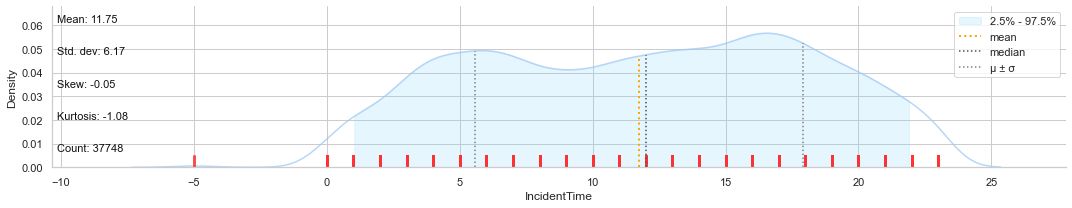

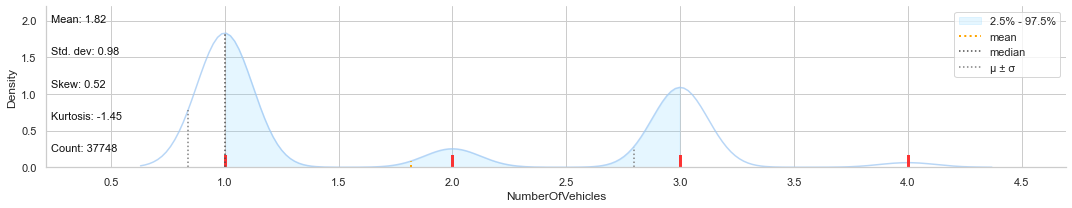

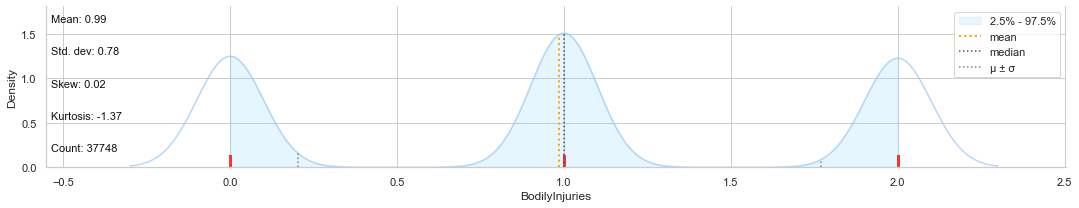

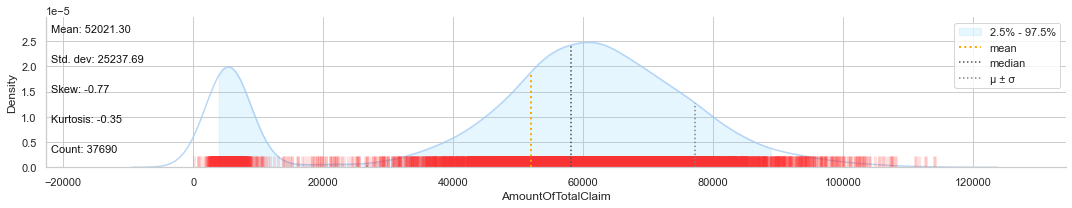

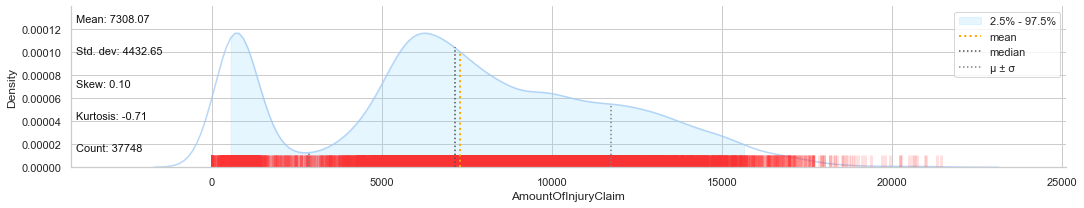

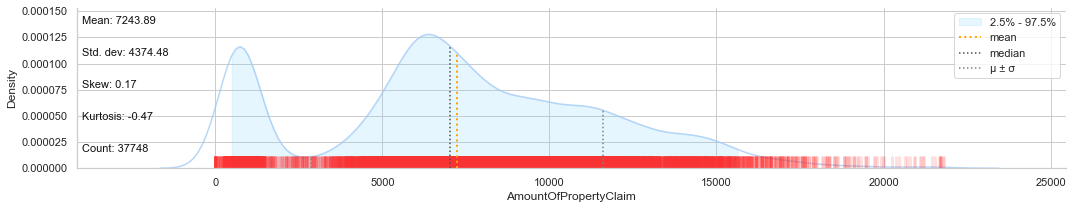

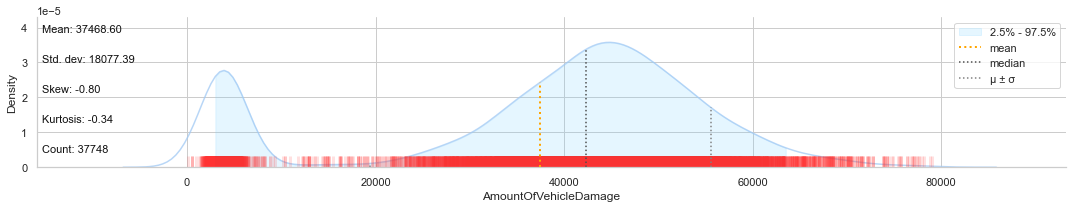

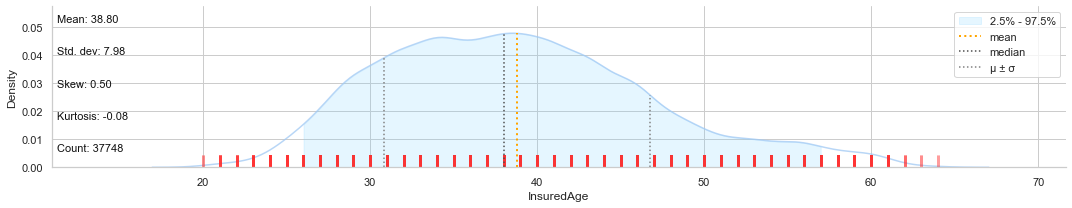

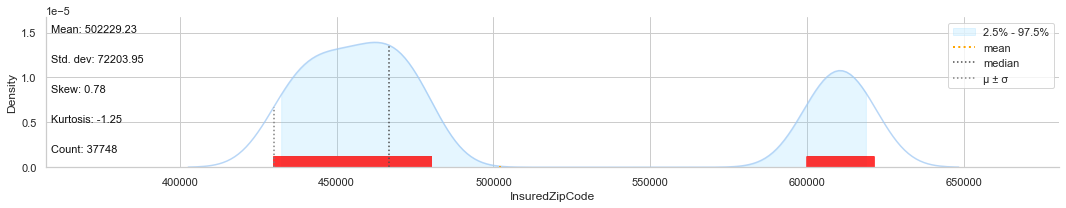

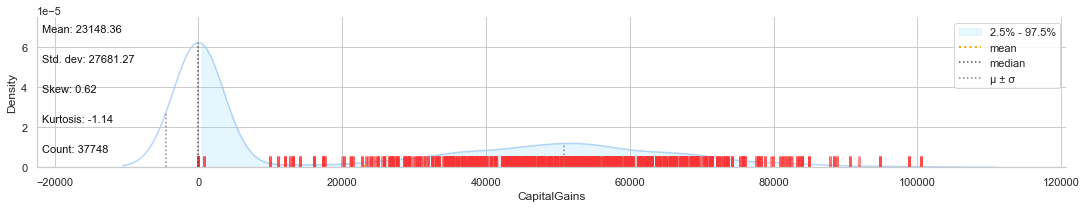

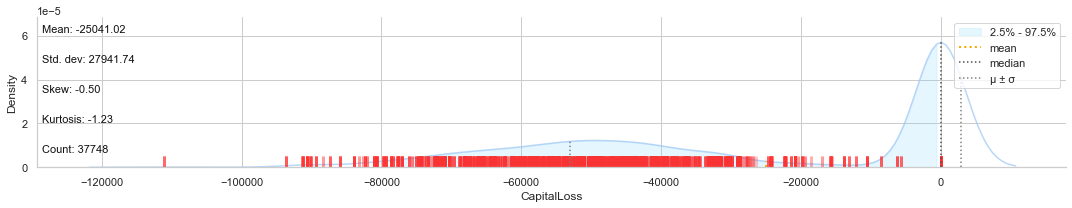

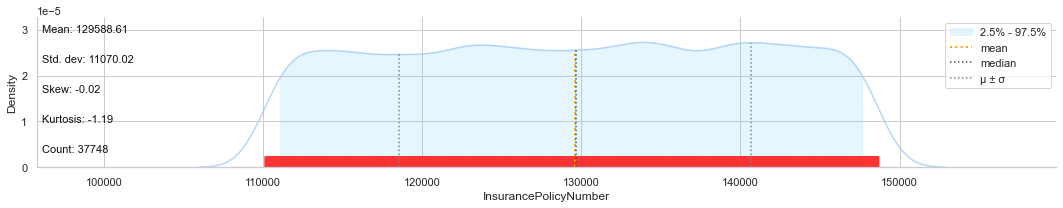

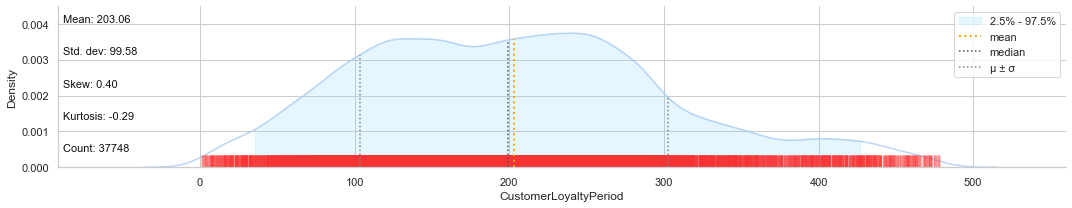

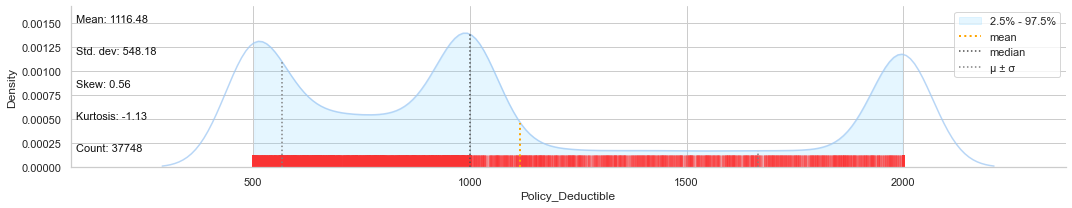

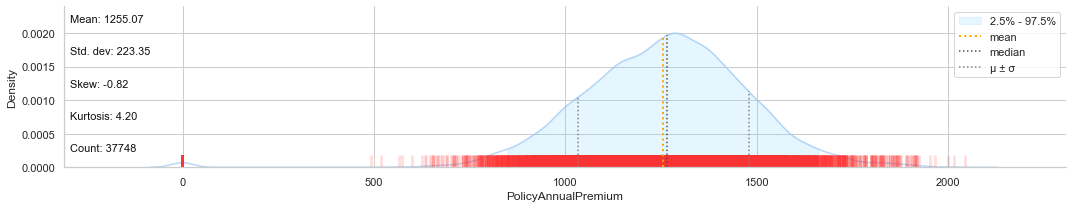

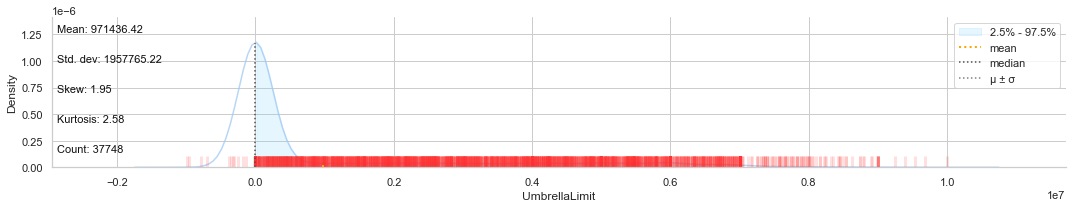

In [71]:
#lets plot a dist_plot using klib
klib.dist_plot(df)

In [72]:
df.columns

Index(['DateOfIncident', 'TypeOfIncident', 'TypeOfCollission',
       'SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState',
       'IncidentCity', 'IncidentTime', 'NumberOfVehicles', 'PropertyDamage',
       'BodilyInjuries', 'Witnesses', 'PoliceReport', 'AmountOfTotalClaim',
       'AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage',
       'InsuredAge', 'InsuredZipCode', 'InsuredGender',
       'InsuredEducationLevel', 'InsuredOccupation', 'InsuredHobbies',
       'CapitalGains', 'CapitalLoss', 'InsurancePolicyNumber',
       'CustomerLoyaltyPeriod', 'DateOfPolicyCoverage', 'InsurancePolicyState',
       'Policy_CombinedSingleLimit', 'Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit', 'InsuredRelationship',
       'VehicleMake', 'VehicleModel', 'VehicleYOM', 'ReportedFraud', 'source'],
      dtype='object')

In [73]:
#Converting the data type of DateOfIncident & DateOfPolicyCoverage to datetime
df['DateOfIncident'] = pd.to_datetime(df['DateOfIncident'])
df['DateOfPolicyCoverage'] = pd.to_datetime(df['DateOfPolicyCoverage'])


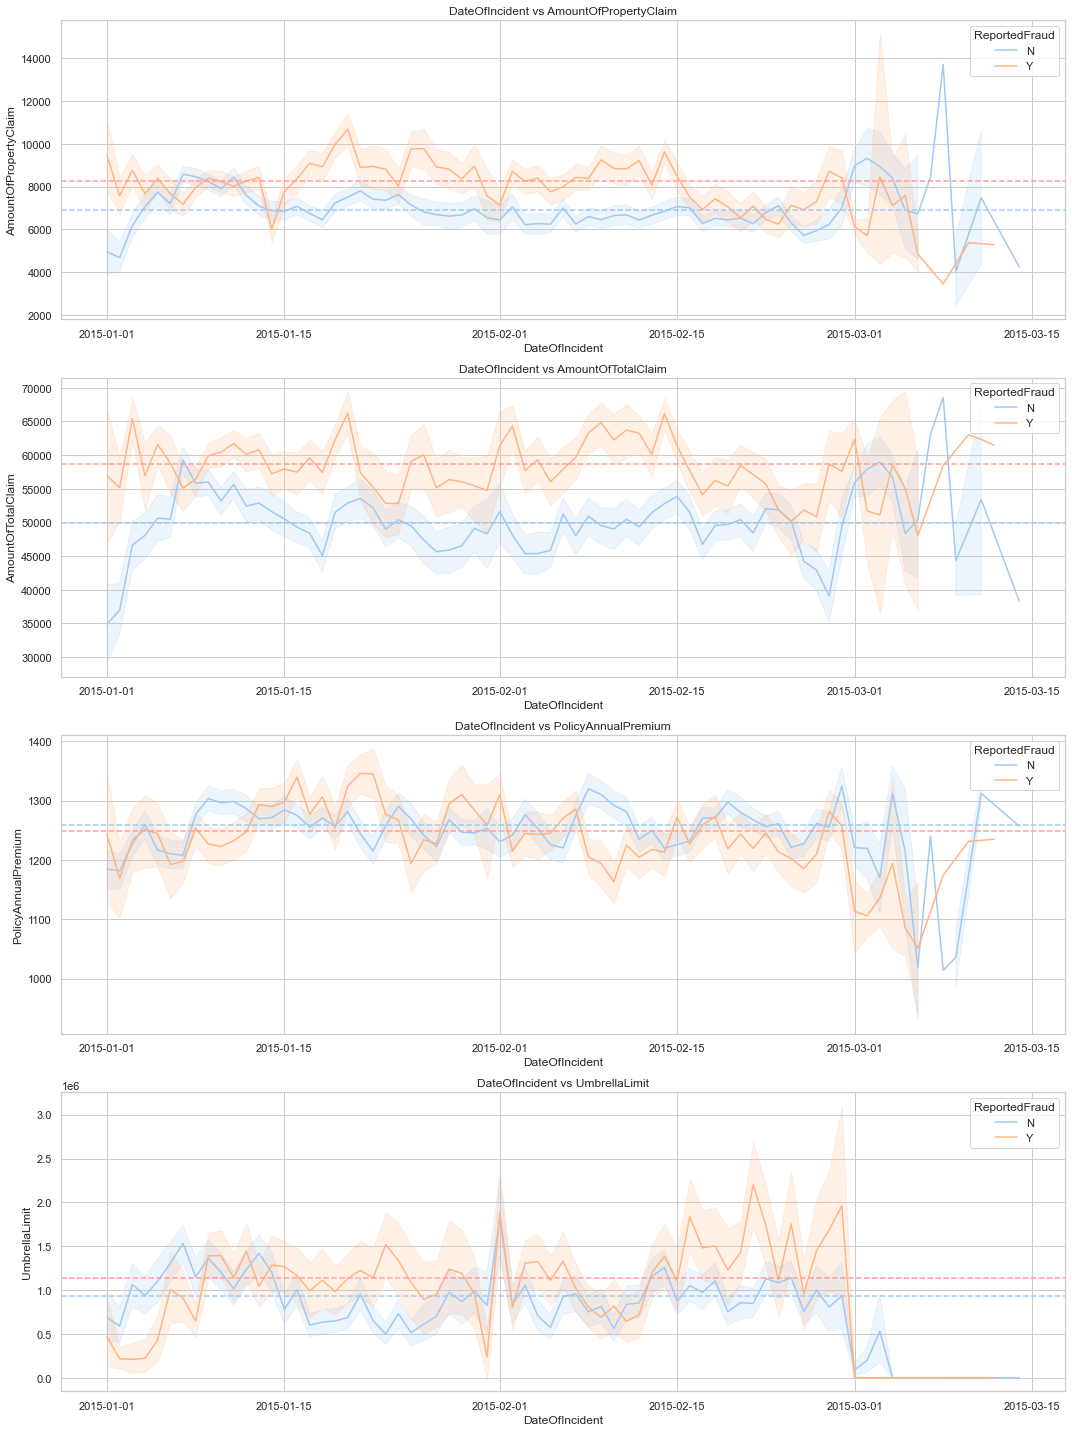

In [74]:
#Visualizing the relation between DateofIncident and AmountOfPropertyClaim using line-plot based on fraud reporting
plt.figure(figsize = (15,20))
plt.subplot(4,1,1)
sns.lineplot(df.DateOfIncident, df.AmountOfPropertyClaim, hue=df.ReportedFraud)
plt.axhline(y=df.groupby('ReportedFraud')['AmountOfPropertyClaim'].mean()[1], color='r', linestyle='--')
plt.axhline(y=df.groupby('ReportedFraud')['AmountOfPropertyClaim'].mean()[0], color='b', linestyle='--')
plt.title("DateOfIncident vs AmountOfPropertyClaim")

#Visualizing the relation between DateofIncident and AmountOfTotalClaim using line-plot based on fraud reporting
plt.subplot(4,1,2)
sns.lineplot(df.DateOfIncident, df.AmountOfTotalClaim, hue=df.ReportedFraud)
plt.axhline(y=df.groupby('ReportedFraud')['AmountOfTotalClaim'].mean()[1], color='r', linestyle='--')
plt.axhline(y=df.groupby('ReportedFraud')['AmountOfTotalClaim'].mean()[0], color='b', linestyle='--')
plt.title("DateOfIncident vs AmountOfTotalClaim")

#Visualizing the relation between DateofIncident and PolicyAnnualPremium using line-plot based on fraud reporting
plt.subplot(4,1,3)
sns.lineplot(df.DateOfIncident, df.PolicyAnnualPremium, hue=df.ReportedFraud)
plt.axhline(y=df.groupby('ReportedFraud')['PolicyAnnualPremium'].mean()[1], color='r', linestyle='--')
plt.axhline(y=df.groupby('ReportedFraud')['PolicyAnnualPremium'].mean()[0], color='b', linestyle='--')
plt.title("DateOfIncident vs PolicyAnnualPremium")

#Visualizing the relation betwen DateofIncident and Policy_Deductible using line-plot based on fraud reporting
plt.subplot(4,1,4)
sns.lineplot(df.DateOfIncident, df.UmbrellaLimit, hue=df.ReportedFraud)
plt.axhline(y=df.groupby('ReportedFraud')['UmbrellaLimit'].mean()[1], color='r', linestyle='--')
plt.axhline(y=df.groupby('ReportedFraud')['UmbrellaLimit'].mean()[0], color='b', linestyle='--')
plt.title("DateOfIncident vs UmbrellaLimit")

plt.tight_layout()

Here I have plotted four line plots to visualize the pattern in our data based on various features

* First line plot is showing the trend how amount of property claim is varying based on date of incident, In this plot we can clearly notice the average property claim of people reported as fraud is significantly higher.

* Second plot is showing the relation of total claim amount with incident date, here also we can observe that the average total claim amount of people reported as fraud is significantly higher.

* Third line plot is showing the relation of PolicyAnnualPremium based on IncidentDate, for this plot there is no significant difference between the average PolicyAnnualPremium of fraud and Not-fraud people.

* Last plot is about Umbrella limit vs Incident Date, here also we can see the average umbrella limit of people making fraud claims is higher than others.

In [75]:
df.describe().T

count           mean           std        min  \
IncidentTime           37748.0      11.752358  6.170602e+00       -5.0   
NumberOfVehicles       37748.0       1.818110  9.783621e-01        1.0   
BodilyInjuries         37748.0       0.986383  7.845334e-01        0.0   
AmountOfTotalClaim     37690.0   52021.301194  2.523769e+04      100.0   
AmountOfInjuryClaim    37748.0    7308.069275  4.432647e+03        0.0   
AmountOfPropertyClaim  37748.0    7243.890166  4.374484e+03        0.0   
AmountOfVehicleDamage  37748.0   37468.600588  1.807739e+04       70.0   
InsuredAge             37748.0      38.798400  7.977104e+00       19.0   
InsuredZipCode         37748.0  502229.227482  7.220395e+04   430104.0   
CapitalGains           37748.0   23148.360178  2.768127e+04        0.0   
CapitalLoss            37748.0  -25041.016743  2.794174e+04  -111100.0   
InsurancePolicyNumber  37748.0  129588.608297  1.107002e+04   110122.0   
CustomerLoyaltyPeriod  37748.0     203.064878  9.957729e+01        0.0   
Policy_Deductible      37748.0    1116.477774  5.481829e+02      500.0   
PolicyAnnualPremium    37748.0    1255.069228  2.233467e+02       -1.0   
UmbrellaLimit          37748.0  971436.422354  1.957765e+06 -1000000.0   

                               25%         50%         75%          max  
IncidentTime                6.0000      12.000      17.000        23.00  
NumberOfVehicles            1.0000       1.000       3.000         4.00  
BodilyInjuries              0.0000       1.000       2.000         2.00  
AmountOfTotalClaim      44122.2500   58199.500   68862.000    114920.00  
AmountOfInjuryClaim      4668.0000    7144.500   10525.250     21450.00  
AmountOfPropertyClaim    4770.0000    7038.000   10283.500     23670.00  
AmountOfVehicleDamage   31754.7500   42314.000   49461.250     79560.00  
InsuredAge                 33.0000      38.000      44.000        64.00  
InsuredZipCode         448310.0000  466634.000  603733.000    620962.00  
CapitalGains                0.0000       0.000   49500.000    100500.00  
CapitalLoss            -50000.0000       0.000       0.000         0.00  
InsurancePolicyNumber  120083.7500  129649.500  139182.250    148619.00  
CustomerLoyaltyPeriod     126.0000     199.000     266.000       479.00  
Policy_Deductible         622.0000    1000.000    1639.250      2000.00  
PolicyAnnualPremium      1120.1525    1265.095    1397.055      2047.59  
UmbrellaLimit               0.0000       0.000  443999.500  10000000.00

After checking this stastical report about numerical data we can do few changes in our data:
* Here there are few entries with negative values in __IncidentDate, PolicyAnnualPremium & UmbrellaLimit column__, which is not realistic so we can replace negative data with 0.
* If we look at the entries in column capital loss all values are negative, so here we can assume that loss is given in negative.

In [76]:
#Dropping unwanted columns from the data
df = df.drop(columns=['InsurancePolicyNumber','InsuredZipCode'],axis=1)

In [77]:
# replace negative values with zero
df['IncidentTime'] = df['IncidentTime'].apply(lambda x: max(0, x))
df['PolicyAnnualPremium'] = df['PolicyAnnualPremium'].apply(lambda x: max(0, x))
df['UmbrellaLimit'] = df['UmbrellaLimit'].apply(lambda x: max(0, x))

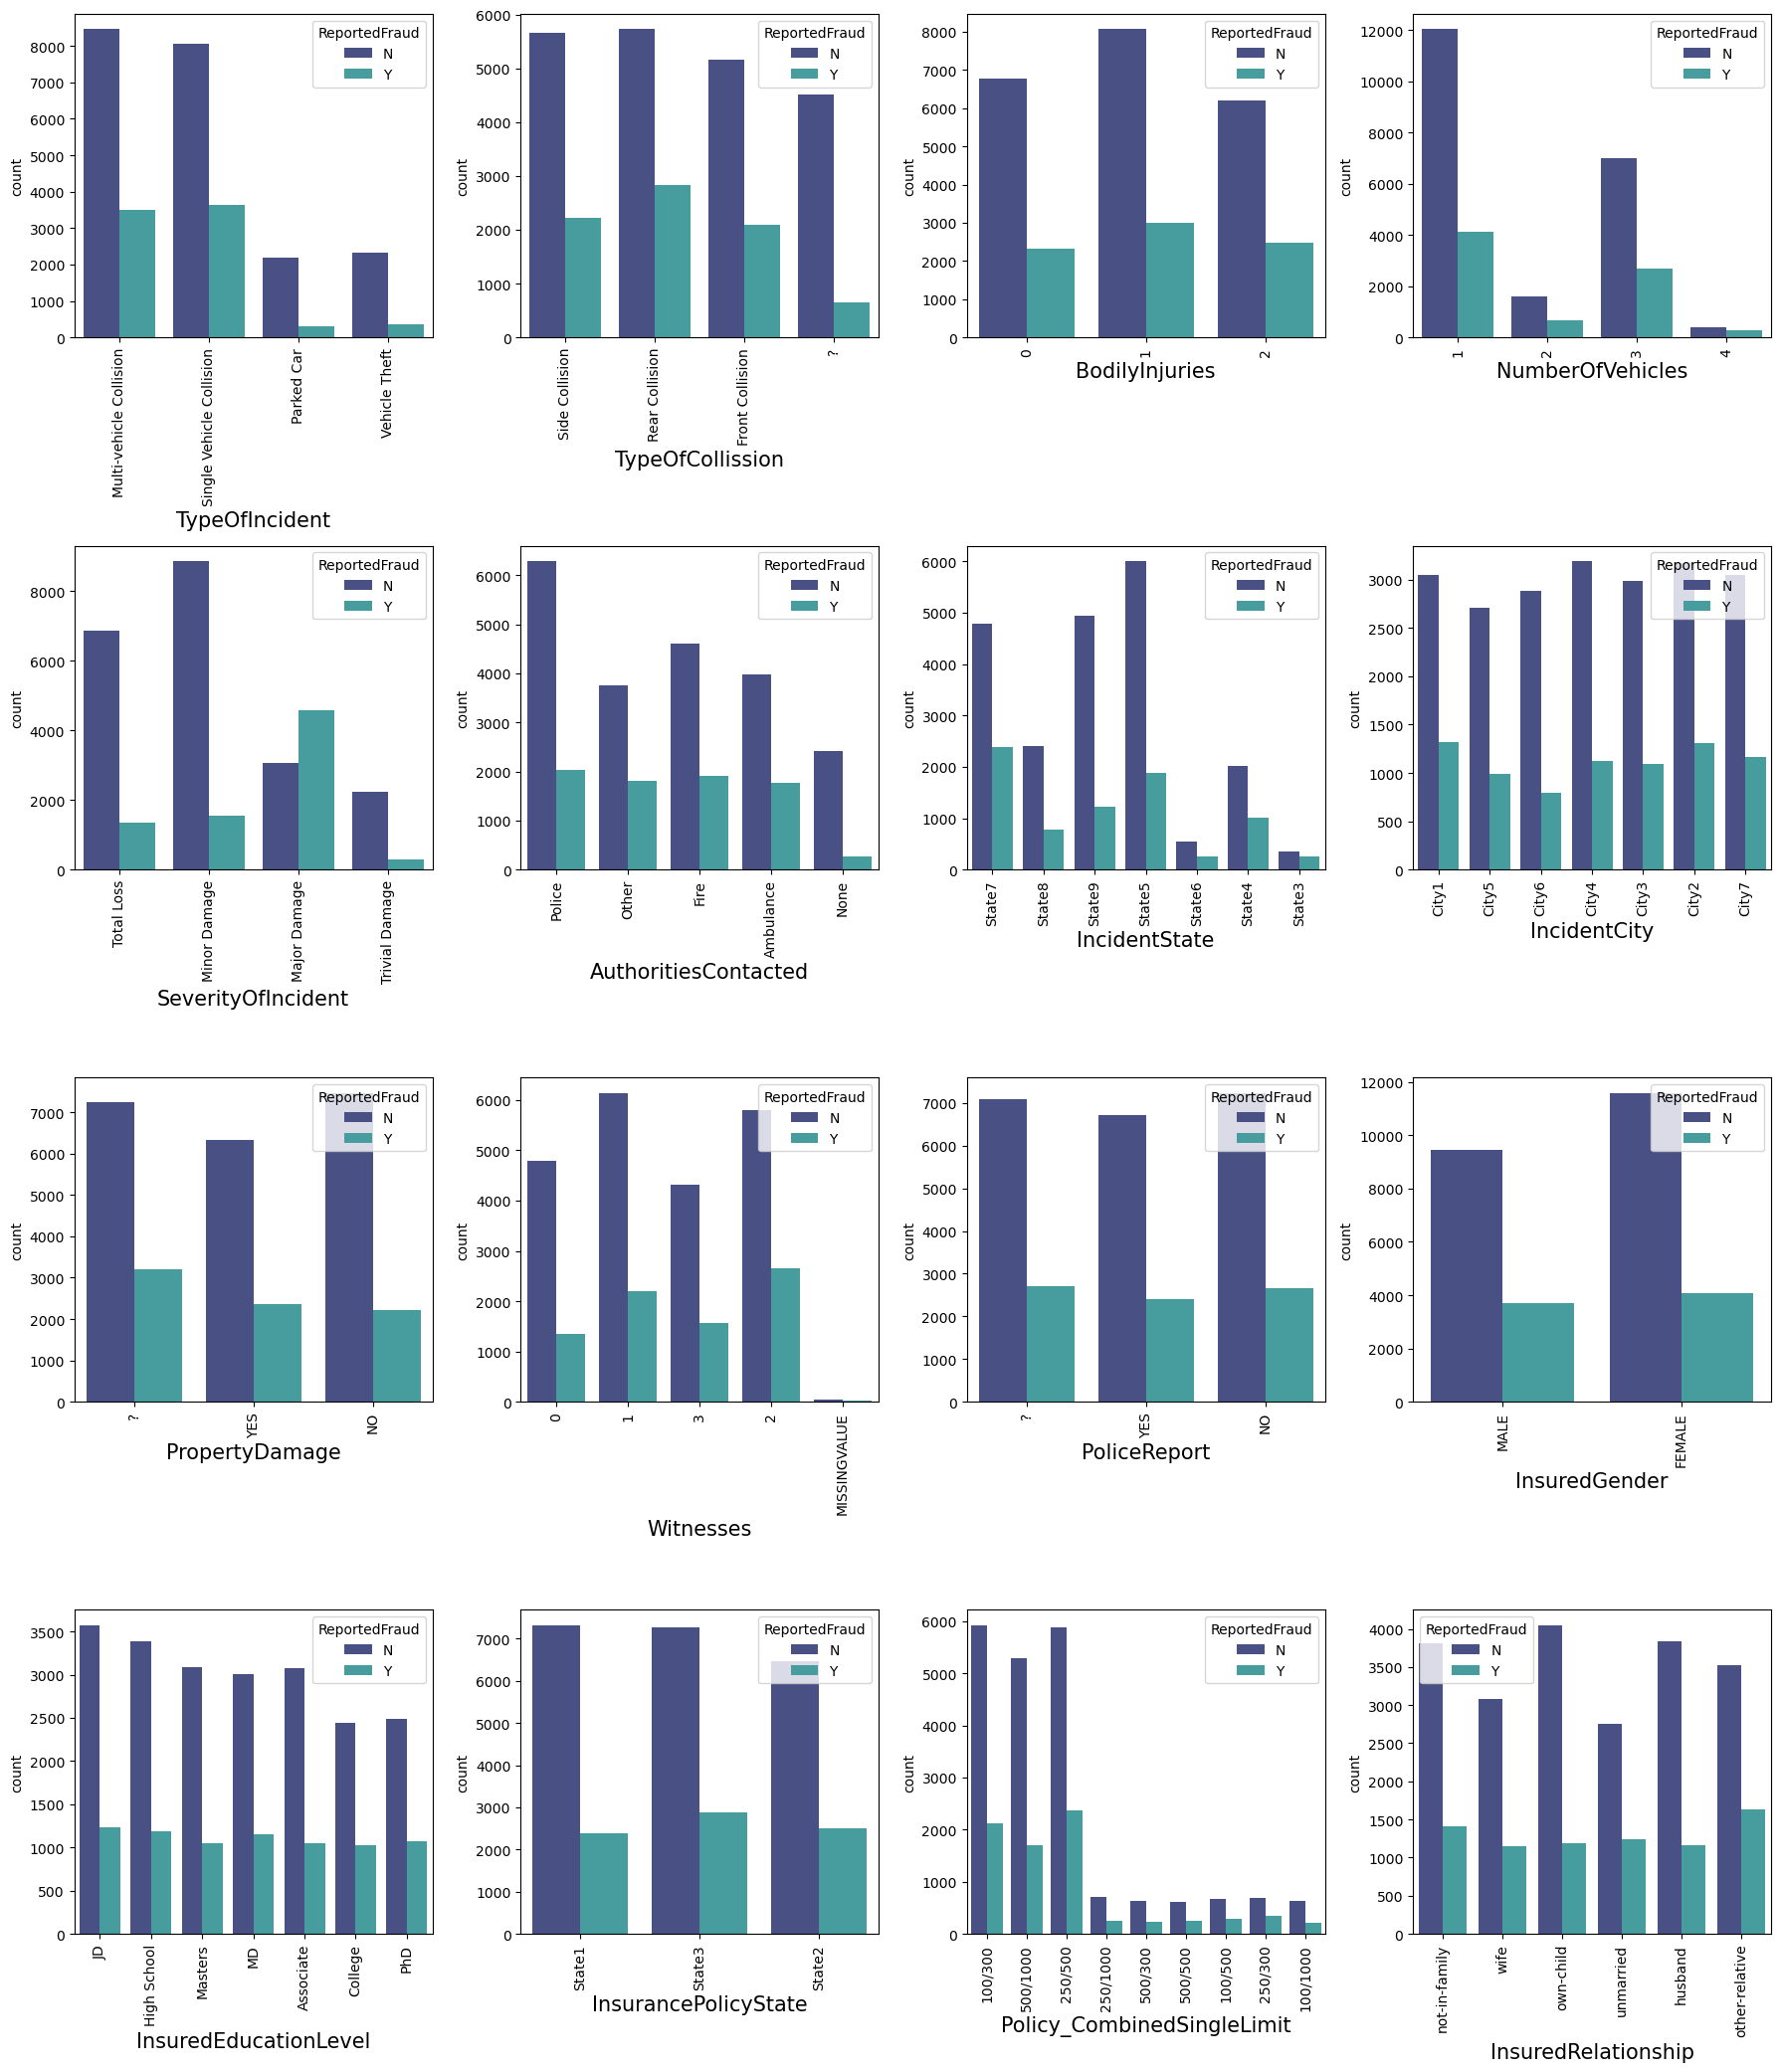

In [78]:
#Lets plot count plots for categorical data
cat_cols = ['TypeOfIncident', 'TypeOfCollission','BodilyInjuries','NumberOfVehicles',
       'SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState','IncidentCity', 'PropertyDamage', 'Witnesses',
       'PoliceReport', 'InsuredGender', 'InsuredEducationLevel','InsurancePolicyState', 'Policy_CombinedSingleLimit', 'InsuredRelationship']
plt.style.use('default')
plt.figure(figsize = (18,25))
plotnumber = 1
for column in cat_cols:
    if plotnumber <=18:
        ax = plt.subplot(5,4,plotnumber)
        sns.countplot(df[column], hue=df.ReportedFraud,palette="mako")
        plt.xlabel(column,fontsize = 15)
        plt.xticks(rotation=90)
    plotnumber+=1
    #plt.show()
plt.tight_layout()

In [79]:
#Lets use policy_csl and make two different columns
df['csl_per_person'] = df.Policy_CombinedSingleLimit.str.split('/', expand=True)[0]
df['csl_per_accident'] = df.Policy_CombinedSingleLimit.str.split('/', expand=True)[1]
#df = df.drop(['Policy_CombinedSingleLimit'],axis=1)

In [80]:
df.head()

DateOfIncident            TypeOfIncident TypeOfCollission  \
0     2015-02-03   Multi-vehicle Collision   Side Collision   
1     2015-02-02   Multi-vehicle Collision   Side Collision   
2     2015-01-15  Single Vehicle Collision   Side Collision   
3     2015-01-19  Single Vehicle Collision   Side Collision   
4     2015-01-09  Single Vehicle Collision   Rear Collision   

  SeverityOfIncident AuthoritiesContacted IncidentState IncidentCity  \
0         Total Loss               Police        State7        City1   
1         Total Loss               Police        State7        City5   
2       Minor Damage                Other        State8        City6   
3       Minor Damage                Other        State9        City6   
4       Minor Damage                 Fire        State8        City6   

   IncidentTime  NumberOfVehicles PropertyDamage  ...  PolicyAnnualPremium  \
0            17                 3              ?  ...              1632.73   
1            10                 3            YES  ...              1255.19   
2            22                 1            YES  ...              1373.38   
3            22                 1            YES  ...              1337.60   
4            10                 1             NO  ...              1353.73   

  UmbrellaLimit InsuredRelationship  VehicleMake  VehicleModel  VehicleYOM  \
0             0       not-in-family         Audi            A5        2008   
1             0       not-in-family         Audi            A5        2006   
2             0                wife   Volkswagen         Jetta        1999   
3             0           own-child   Volkswagen         Jetta        2003   
4       4279863           unmarried       Toyota           CRV        2010   

   ReportedFraud  source csl_per_person csl_per_accident  
0              N   train            100              300  
1              N   train            100              300  
2              N   train            500             1000  
3              N   train            500             1000  
4              N   train            100              300  

[5 rows x 39 columns]

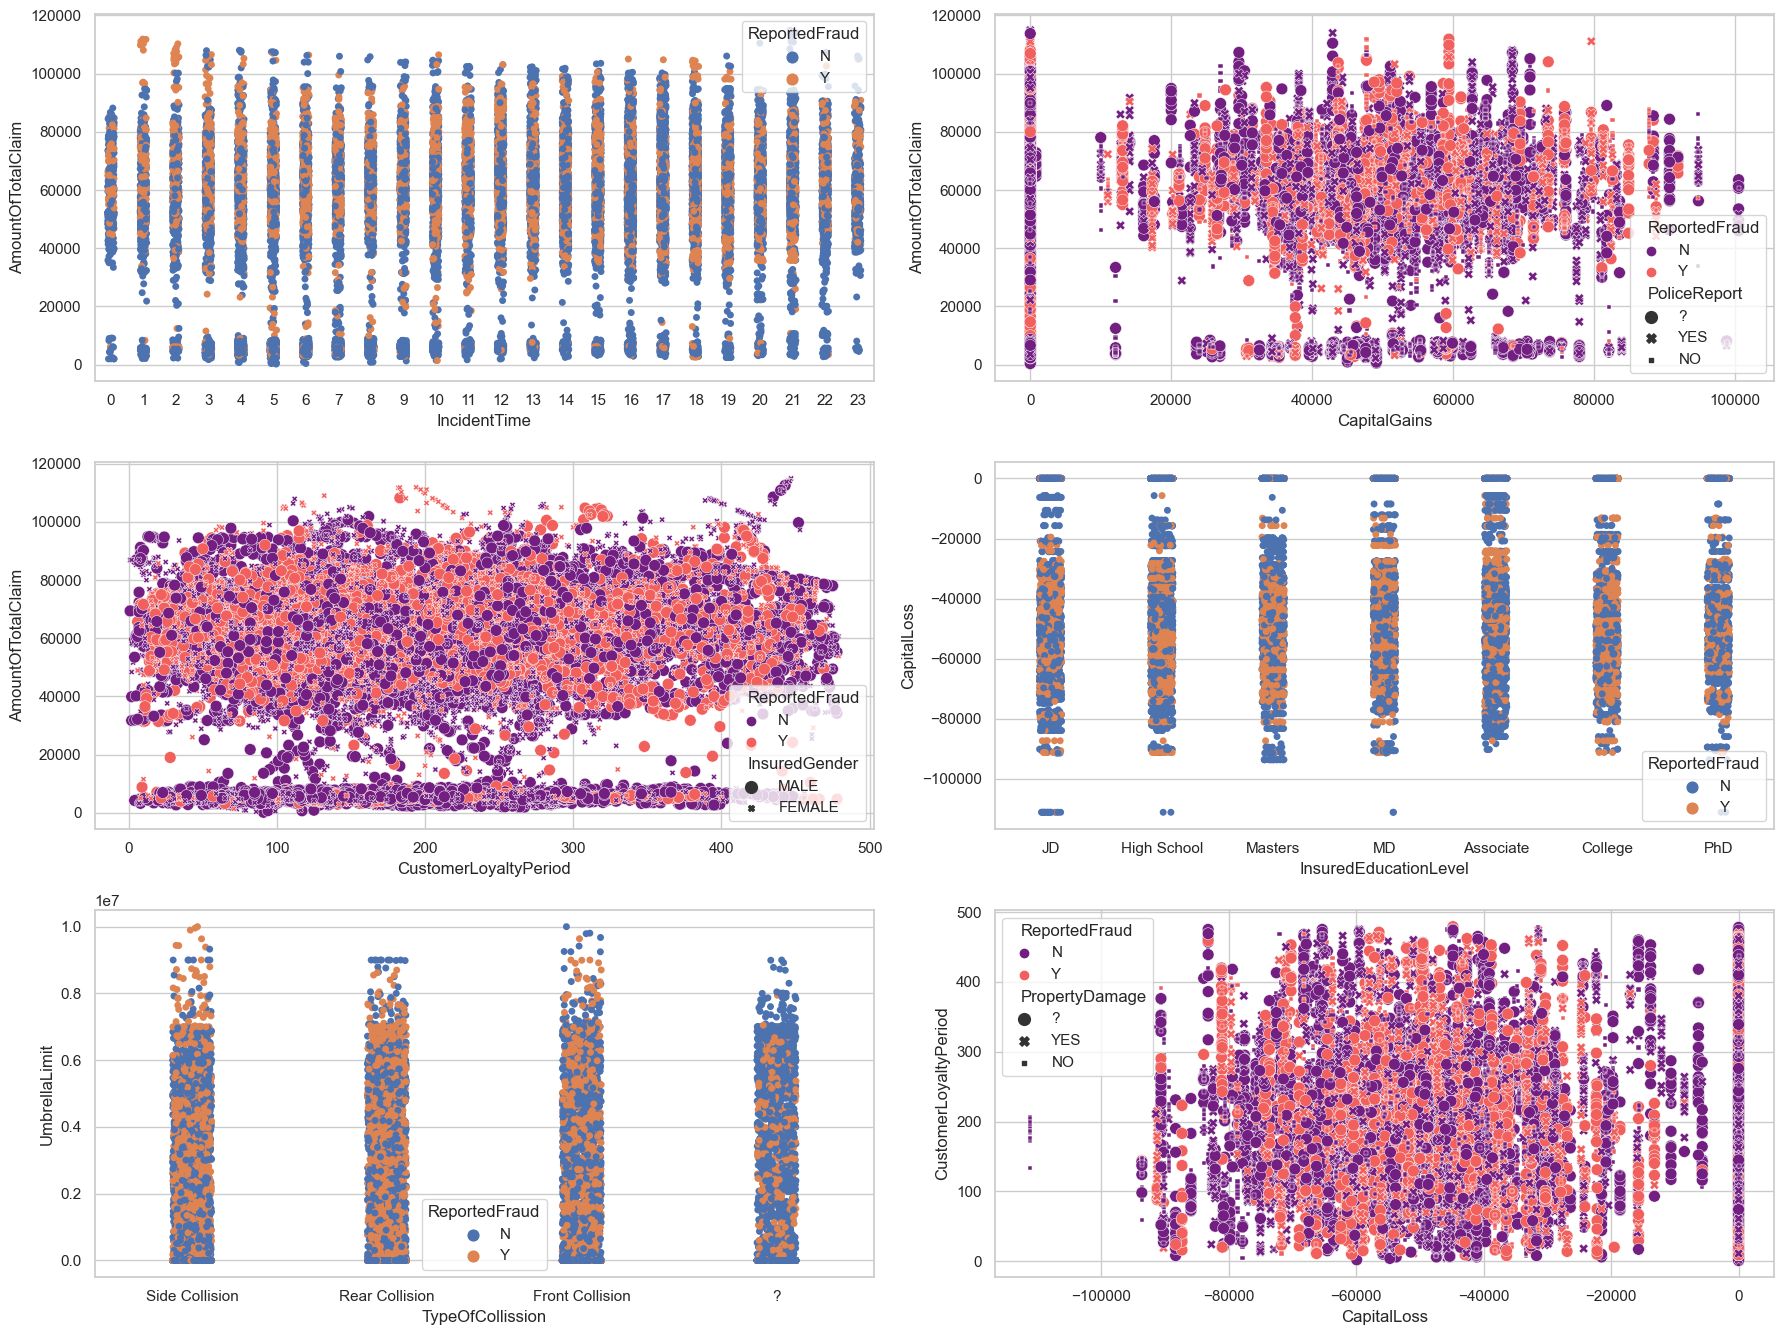

In [81]:
plt.figure(figsize = (18,22))
sns.set_theme(style="whitegrid")
plt.subplot(5,2,1)
sns.stripplot(df.IncidentTime,df.AmountOfTotalClaim, hue=df.ReportedFraud)
plt.subplot(5,2,2)
sns.scatterplot(df.CapitalGains,df.AmountOfTotalClaim, hue=df.ReportedFraud, style=df.PoliceReport,palette="magma", size=df.PoliceReport,
               legend="full")
plt.subplot(5,2,3)
sns.scatterplot(df.CustomerLoyaltyPeriod,df.AmountOfTotalClaim, hue=df.ReportedFraud, style=df.InsuredGender,palette="magma",size=df.InsuredGender,
               legend="full")

plt.subplot(5,2,4)
sns.stripplot(df.InsuredEducationLevel,df.CapitalLoss, hue=df.ReportedFraud)
plt.subplot(5,2,5)
sns.stripplot(df.TypeOfCollission,df.UmbrellaLimit, hue=df.ReportedFraud)
plt.subplot(5,2,6)
sns.scatterplot(df.CapitalLoss,df.CustomerLoyaltyPeriod, hue=df.ReportedFraud, style=df.PropertyDamage, palette="magma",size=df.PropertyDamage)
plt.tight_layout()

Observations from above plots:
    
* From our first strip-plot we can conclude that there is no any strong relation between total claim amount and incident date, but we can say that the probability of reporting fraud is quit less when the total claim amount is below 40,000.

* Our second plot is scatter plot showing relation between AmountOfTotalClaim and Capital gain, we can see many people reported capital gain as 0. Here for this plot I have selected style parameter as PoliceReport to check whether '?' sign is following any particular pattern based on fraud reporting. Unfortunately it's not showing any noticiable pattern so I have decided to treat it as a separate class.

* I have plotted scatterplot with AmountOfTotalClaim, CustomerLoyaltyPeriod and Insured Gender, but there is no any strong relation between these attributes.

* Fourth plot is a strip-plot to visualize the relation among InsuredEducationLevel, CapitalLoss and fraud report, here every class of Education level is showing both the possibilities of fraud reporting. We can also see that the chances of reporting fraud are less at extreme values of capital loss.

* Next strip-plot is to make a decision about __"?"__ sign in TypeOfCollision column. Here we can clearly observe that this particular class with ? sign is having less fraud reportings compared to other classes, so I will treat it as a separate class instead of replacing with any other. 

In [82]:
df['InsuredGender'].value_counts()

FEMALE    20484
MALE      17226
Name: InsuredGender, dtype: int64

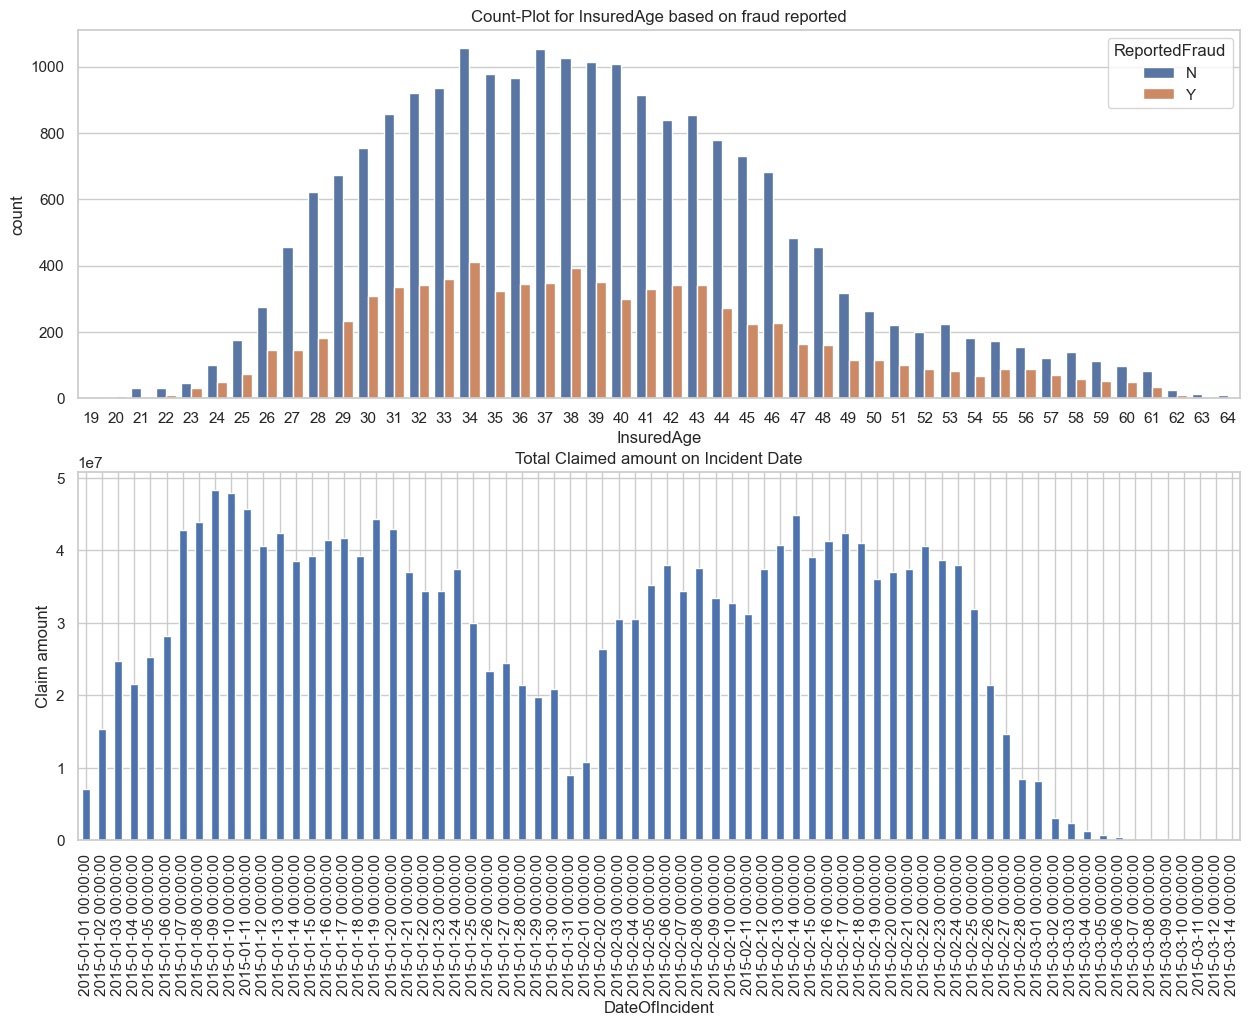

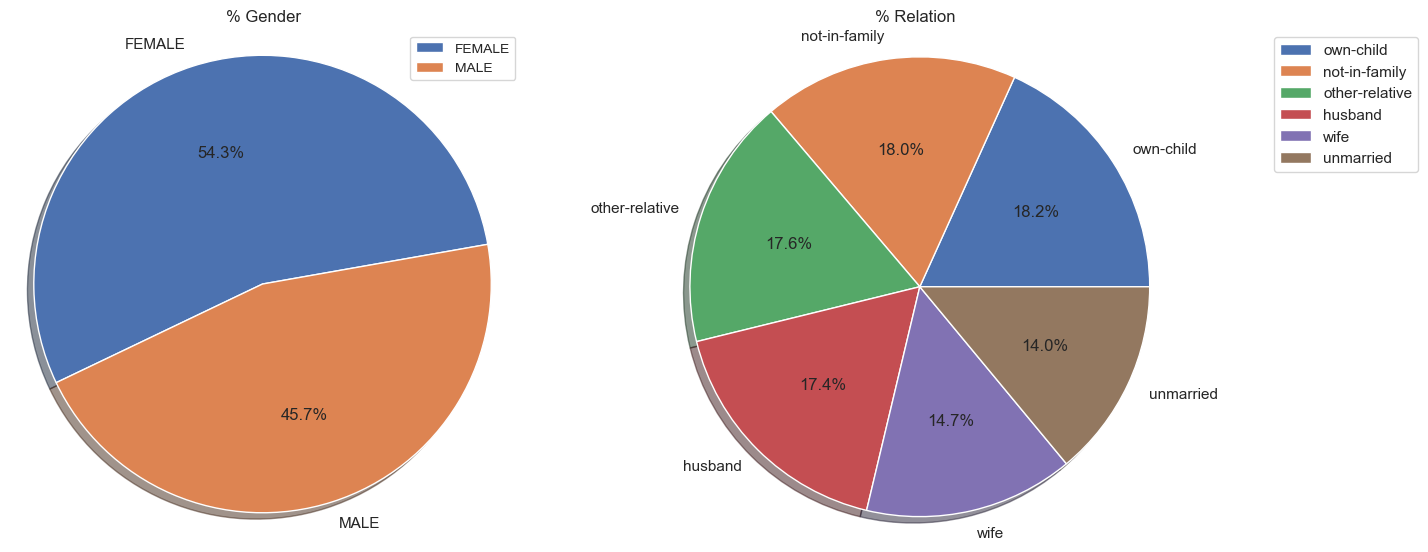

In [83]:
#lets check the fraud_report based on age
plt.figure(figsize = (15,22))
plt.subplot(4,1,1)
sns.countplot(x = 'InsuredAge', hue = 'ReportedFraud', data = df)
plt.title('Count-Plot for InsuredAge based on fraud reported')

# plotting barplot for incident_date vs Claim amount ($)
plt.subplot(4,1,2)
ax = df.groupby('DateOfIncident').AmountOfTotalClaim.sum().plot.bar(ylim=0)
ax.set_ylabel('Claim amount')
plt.title('Total Claimed amount on Incident Date')
plt.show()

plt.figure(figsize = (15,22))
plt.subplot(4,2,3)
plt.pie(df['InsuredGender'].value_counts().values, labels = df['InsuredGender'].value_counts().index,
        startangle=10, shadow = True, autopct='%1.1f%%')
plt.title('% Gender ')
plt.legend()
plt.legend(prop={'size': 10})
plt.axis('square')

plt.subplot(4,2,4)
plt.pie( df["InsuredRelationship"].value_counts().values, labels = df["InsuredRelationship"].value_counts().index, shadow = True, autopct='%1.1f%%')
fig = plt.gcf()
plt.title('% Relation ')
plt.axis('equal')
plt.legend(prop={'size': 12})
plt.legend( bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()

#### Observations:
* The first count plot displays the ratio of reported fraud cases versus non-fraud cases by age group. The majority of cases were reported for individuals between 27 to 50 years of age.

* The second bar plot visualizes the total claimed amount for each incident date, revealing that the claim amounts were lower during the initial days of the month compared to later dates

* The next pie chart displays the male-to-female customer ratio, with females accounting for 54.3% and males comprising 45.7% of the total customer population.

* The final pie chart displays the percentage breakdown of customer relational statuses, with the data showing an almost equal distribution among all classes.



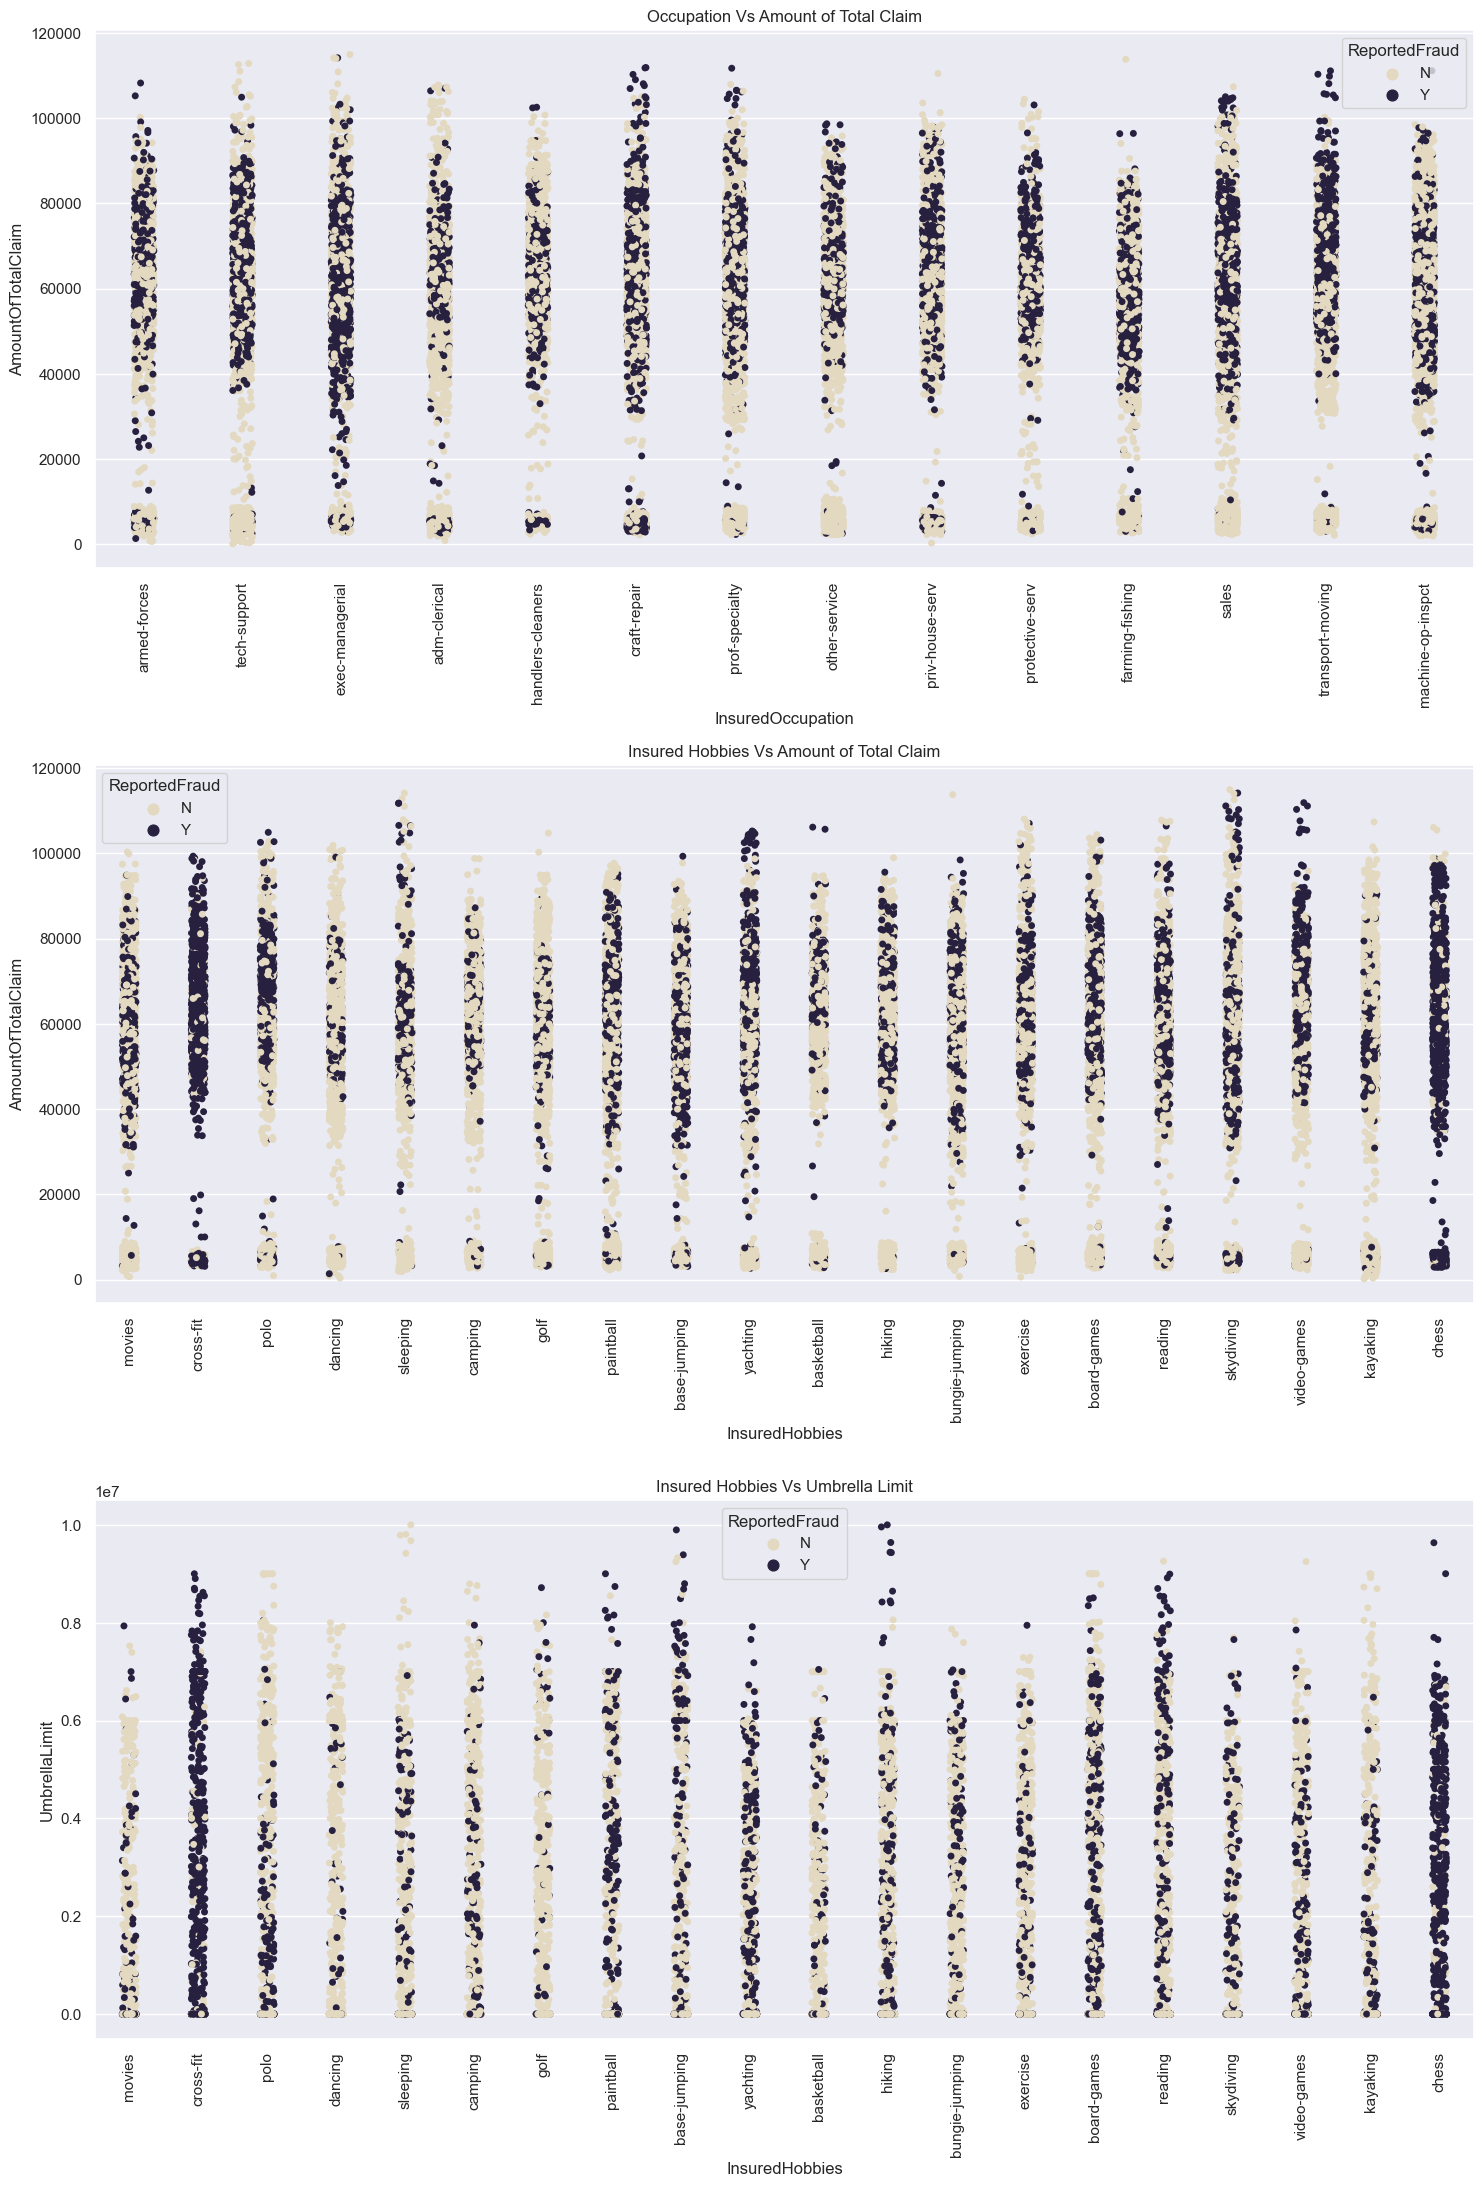

In [84]:
#Lets plot some strip-plots to analyse the data
#InsuredOccupation vs AmountOfTotalClaim
sns.set_theme()
sns.set_context("notebook")
plt.figure(figsize = (15,28))
plt.subplot(4,1,1)
sns.stripplot(df.InsuredOccupation,df.AmountOfTotalClaim,hue=df.ReportedFraud, palette="ch:s=-.2,r=.6")
plt.xticks(rotation=90)
plt.title("Occupation Vs Amount of Total Claim")

plt.subplot(4,1,2)
sns.stripplot(df.InsuredHobbies,df.AmountOfTotalClaim,hue=df.ReportedFraud, palette="ch:s=-.2,r=.6")
plt.xticks(rotation=90)
plt.title("Insured Hobbies Vs Amount of Total Claim")
plt.tight_layout()

plt.subplot(4,1,3)
sns.stripplot(df.InsuredHobbies,df.UmbrellaLimit,hue=df.ReportedFraud, palette="ch:s=-.2,r=.6")
plt.xticks(rotation=90)
plt.title("Insured Hobbies Vs Umbrella Limit")
plt.tight_layout()

* Based on the analysis of the above strip plots, we can conclude that individuals working in the adm-clerical, machine-op-inspect, and prof-speciality occupations are less likely to be reported for fraud compared to other occupations.

* Additionally, there is a high likelihood of fraud reporting for individuals with cross-fit and chess as hobbies, while individuals with hobbies such as dancing, golf, and basketball are less likely to be reported for fraud.

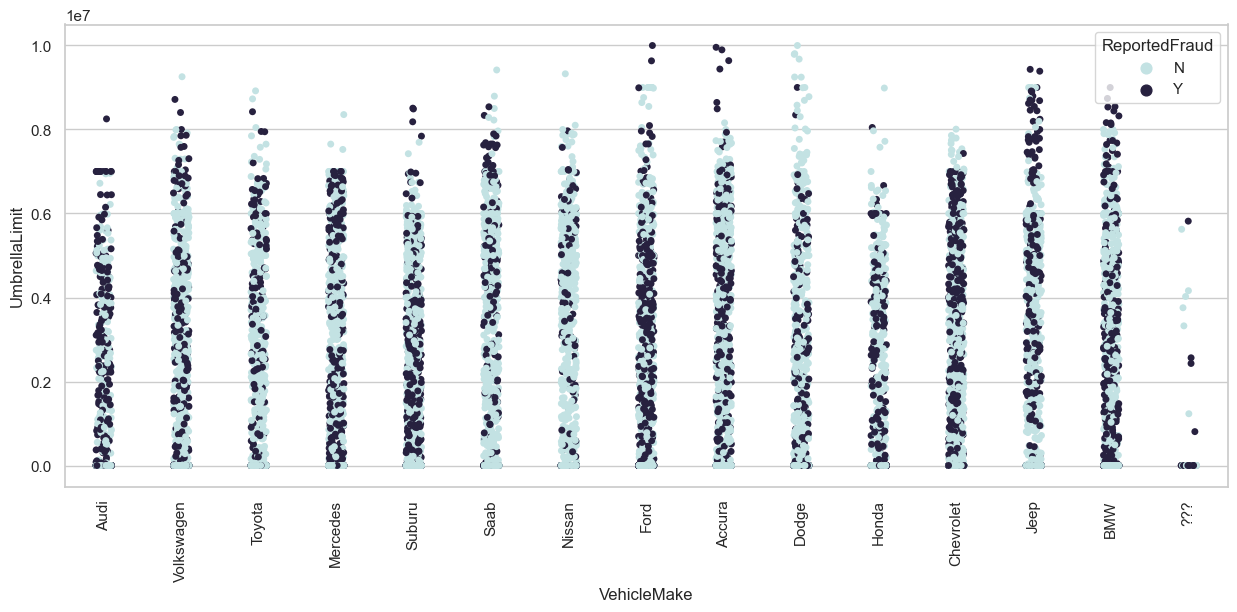

In [85]:
plt.figure(figsize = (15,6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.stripplot(df.VehicleMake,df.UmbrellaLimit,hue=df.ReportedFraud, palette="ch:start=.2,rot=-.3")
plt.xticks(rotation=90)
plt.show()

The strip plot displays the relationship between the umbrella limit, vehicle make, and fraud reporting. From this plot, it is evident that individuals who own Saab, Nissan, and Dodge vehicles have a lower likelihood of being reported for fraud compared to other vehicle makes.

### Chi-Square and Phi-Coefficient Test to check the relation between Categorical attributes and Target Column

In [86]:
cat_cols = ['TypeOfIncident', 'InsuredHobbies','TypeOfCollission','VehicleModel','SeverityOfIncident', 'AuthoritiesContacted', 
            'IncidentState','IncidentCity', 'PropertyDamage', 'Witnesses','PoliceReport', 'InsuredGender', 'InsuredEducationLevel',
            'InsurancePolicyState', 'Policy_CombinedSingleLimit', 'InsuredRelationship']

data = pd.get_dummies(df, columns=cat_cols)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
data = data.drop(numeric_cols, axis=1)
data = data.drop(['DateOfIncident','DateOfPolicyCoverage'], axis=1)
# Perform the Chi-Square test for each binary variable
results = []
for col in data.columns:
    if col != 'ReportedFraud':
        contingency_table = pd.crosstab(data[col], data['ReportedFraud'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        phi = ((chi2**2)/data.shape[0])**0.5
        results.append({'Variable': col, 'Chi-Square': chi2, 'P-value': p, 'Degrees of Freedom': dof, 'Phi Coefficient': phi})

# Create a dataframe of results
results_df = pd.DataFrame(results)

# Print the dataframe
results_df = results_df.sort_values('Phi Coefficient',ascending = False)
results_df

Variable   Chi-Square        P-value  \
73     SeverityOfIncident_Major Damage  5729.659455   0.000000e+00   
15                InsuredHobbies_chess  1808.684781   0.000000e+00   
16            InsuredHobbies_cross-fit  1540.402539   0.000000e+00   
74     SeverityOfIncident_Minor Damage  1235.128028  1.416086e-270   
30                  TypeOfCollission_?   654.038812  2.956332e-144   
..                                 ...          ...            ...   
129  InsuredRelationship_not-in-family     0.016159   8.988474e-01   
105                    PoliceReport_NO     0.010760   9.173836e-01   
103             Witnesses_MISSINGVALUE     0.000728   9.784818e-01   
25              InsuredHobbies_reading     0.000000   1.000000e+00   
3                               source     0.000000   1.000000e+00   

     Degrees of Freedom  Phi Coefficient  
73                    1        29.490480  
15                    1         9.309276  
16                    1         7.928431  
74                    1         6.357187  
30                    1         3.366329  
..                  ...              ...  
129                   1         0.000083  
105                   1         0.000055  
103                   1         0.000004  
25                    1         0.000000  
3                     0         0.000000  

[134 rows x 5 columns]

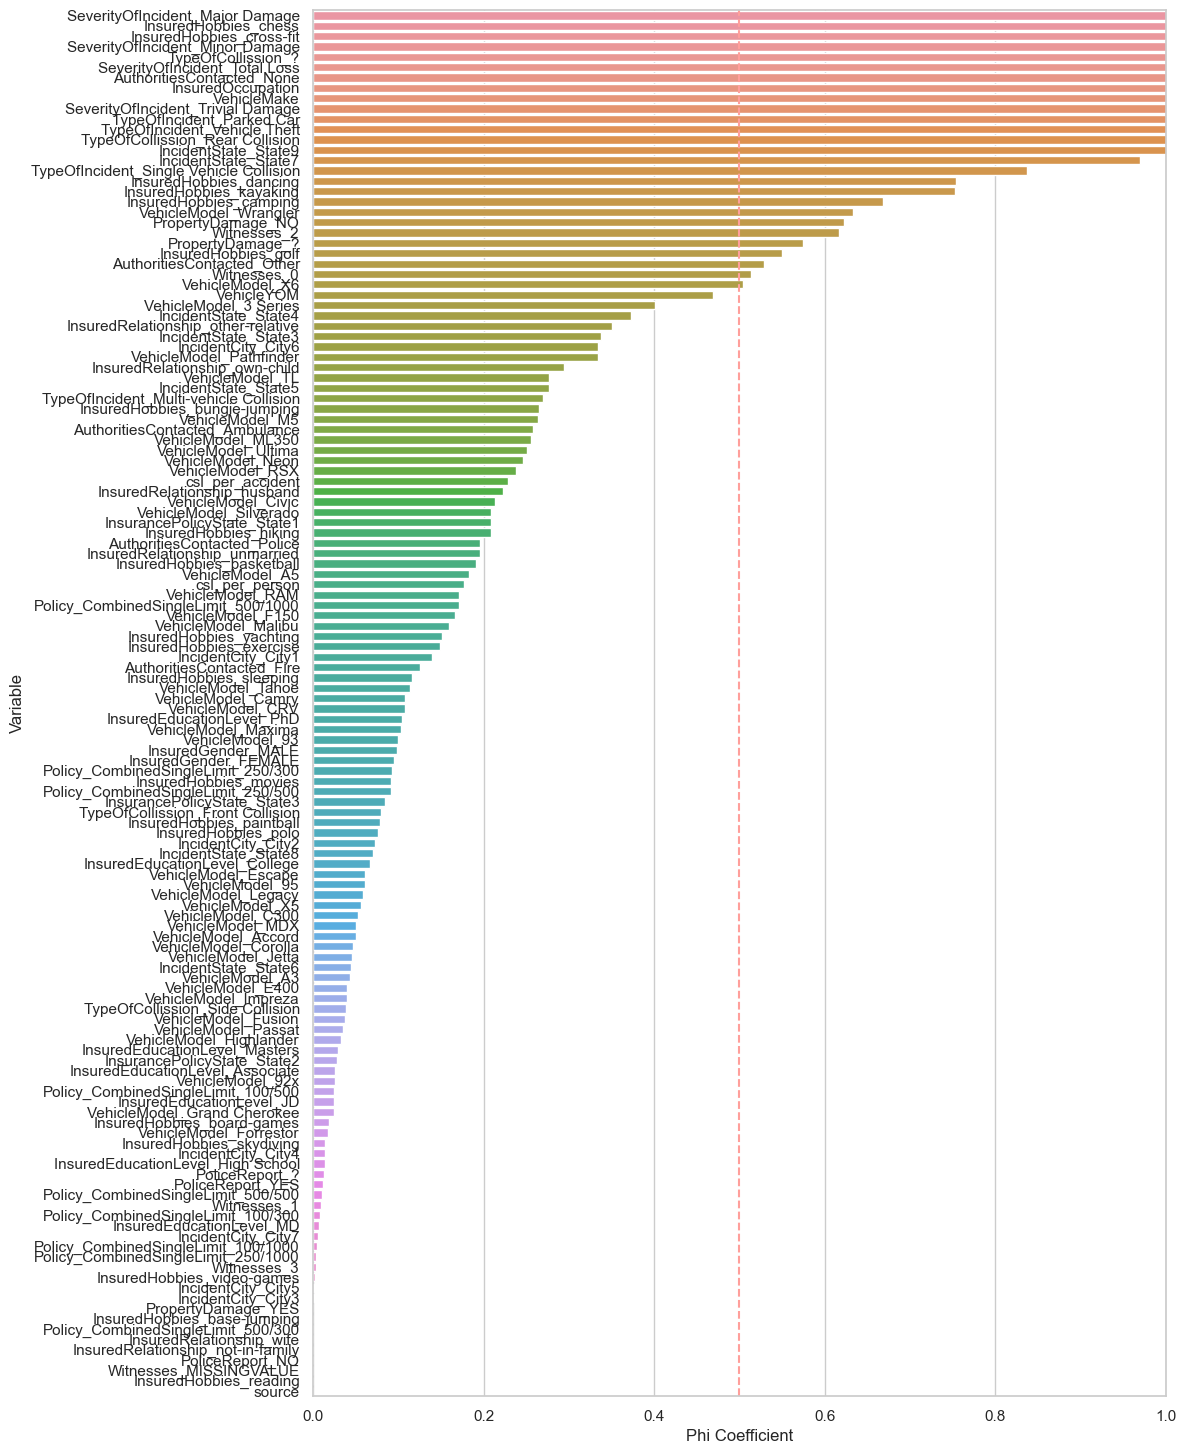

In [87]:
f, ax = plt.subplots(figsize=(11, 18))
sns.barplot(results_df['Phi Coefficient'],results_df['Variable'])
ax.set(xlim=(0, 1))
plt.axvline(x= 0.5, color='r', linestyle='--')
#plt.xticks(rotation=90)
plt.show()

Great here we have plotted a barchart to represent the relation of every categorical attribute with our target column based on Phi-Coefficient value. The phi-coefficient near to 1 indicates a good relation between two variables, based on this criteria we can decide the important features for making predictions.

In [88]:
#lets replace label data with 0 & 1
df['ReportedFraud'].replace('Y', 1, inplace = True)
df['ReportedFraud'].replace('N', 0, inplace = True)

## Correlation - Heat Map 

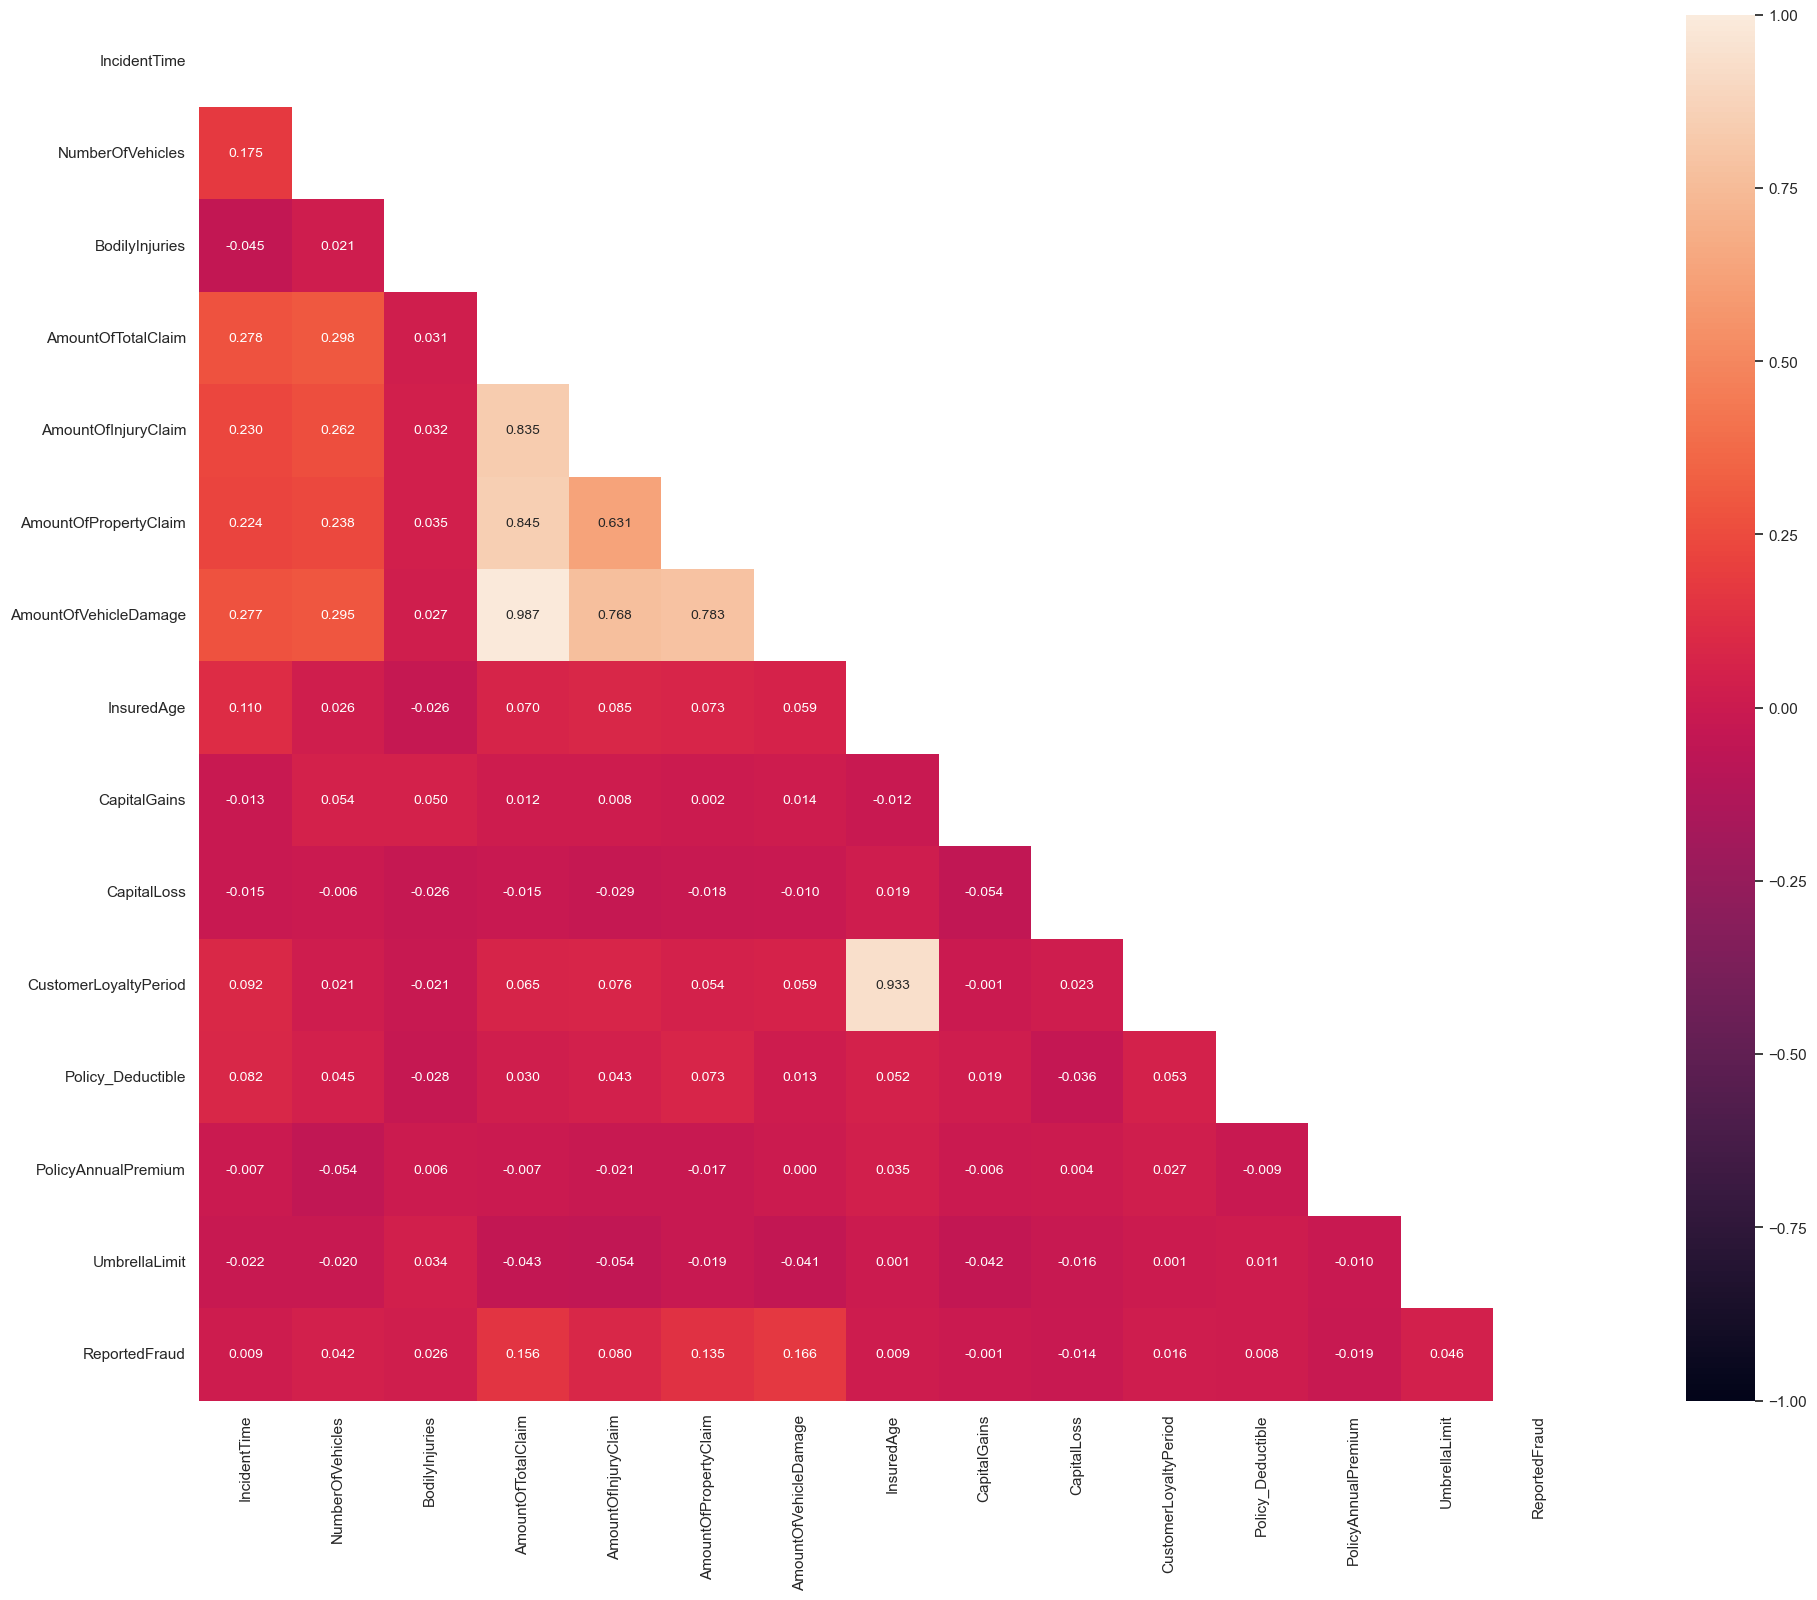

In [89]:
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(26,18))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f',
            annot_kws={'size':10},mask=upper_triangle)
plt.show()

By looking at the above Correlation heat map we can see that we don't have any variable which is showing very strong relation with target column.
However few variables like amount of total claim, Vehicle damage and Amount of property claim are showing some correlation coefficient with target.

In [90]:
df.head()

DateOfIncident            TypeOfIncident TypeOfCollission  \
0     2015-02-03   Multi-vehicle Collision   Side Collision   
1     2015-02-02   Multi-vehicle Collision   Side Collision   
2     2015-01-15  Single Vehicle Collision   Side Collision   
3     2015-01-19  Single Vehicle Collision   Side Collision   
4     2015-01-09  Single Vehicle Collision   Rear Collision   

  SeverityOfIncident AuthoritiesContacted IncidentState IncidentCity  \
0         Total Loss               Police        State7        City1   
1         Total Loss               Police        State7        City5   
2       Minor Damage                Other        State8        City6   
3       Minor Damage                Other        State9        City6   
4       Minor Damage                 Fire        State8        City6   

   IncidentTime  NumberOfVehicles PropertyDamage  ...  PolicyAnnualPremium  \
0            17                 3              ?  ...              1632.73   
1            10                 3            YES  ...              1255.19   
2            22                 1            YES  ...              1373.38   
3            22                 1            YES  ...              1337.60   
4            10                 1             NO  ...              1353.73   

  UmbrellaLimit InsuredRelationship  VehicleMake  VehicleModel  VehicleYOM  \
0             0       not-in-family         Audi            A5        2008   
1             0       not-in-family         Audi            A5        2006   
2             0                wife   Volkswagen         Jetta        1999   
3             0           own-child   Volkswagen         Jetta        2003   
4       4279863           unmarried       Toyota           CRV        2010   

   ReportedFraud  source csl_per_person csl_per_accident  
0            0.0   train            100              300  
1            0.0   train            100              300  
2            0.0   train            500             1000  
3            0.0   train            500             1000  
4            0.0   train            100              300  

[5 rows x 39 columns]

## Data Processing

In [91]:
#Creating a column named as Vehicle_age using VehicleYOM
df['VehicleYOM'] = df['VehicleYOM'].astype(int)
df['Vehicle_age'] = 2015-df['VehicleYOM']
#We have created a new column using VehicleYOM so we can drop this column
df.drop(columns=['VehicleYOM'],inplace=True)

In [92]:
#Creating a new column for incident month
df['IncidentMonth'] = df['DateOfIncident'].dt.strftime('%m')

In [93]:
#replacing All '?' sign with other category
df['TypeOfCollission'] = df['TypeOfCollission'].replace('?', 'Other')
df['PropertyDamage'] = df['PropertyDamage'].replace('?', 'Other')
df['PoliceReport'] = df['PoliceReport'].replace('?', 'Other')
df['VehicleMake'] = df['VehicleMake'].replace('???', 'Other')
df['Witnesses'] = df['Witnesses'].replace('MISSINGVALUE', '0')

For now I am just replacing these data with Other category, after checking the model performance we can impute these values using different techniques like k-nearest neighbour or using any classifier. And finally select the optimum method for the task.

### Replacing Missing Values

In [94]:
df['InsuredGender'] = df['InsuredGender'].fillna(df['InsuredGender'].mode()[0])
df['AmountOfTotalClaim'] = df['AmountOfTotalClaim'].fillna(df['AmountOfTotalClaim'].mean())

In [95]:
#dropping unwanted columns
df = df.drop(columns=['DateOfIncident','DateOfPolicyCoverage','Policy_CombinedSingleLimit'],axis=1)

## Outlier Checking Using Box-Plots

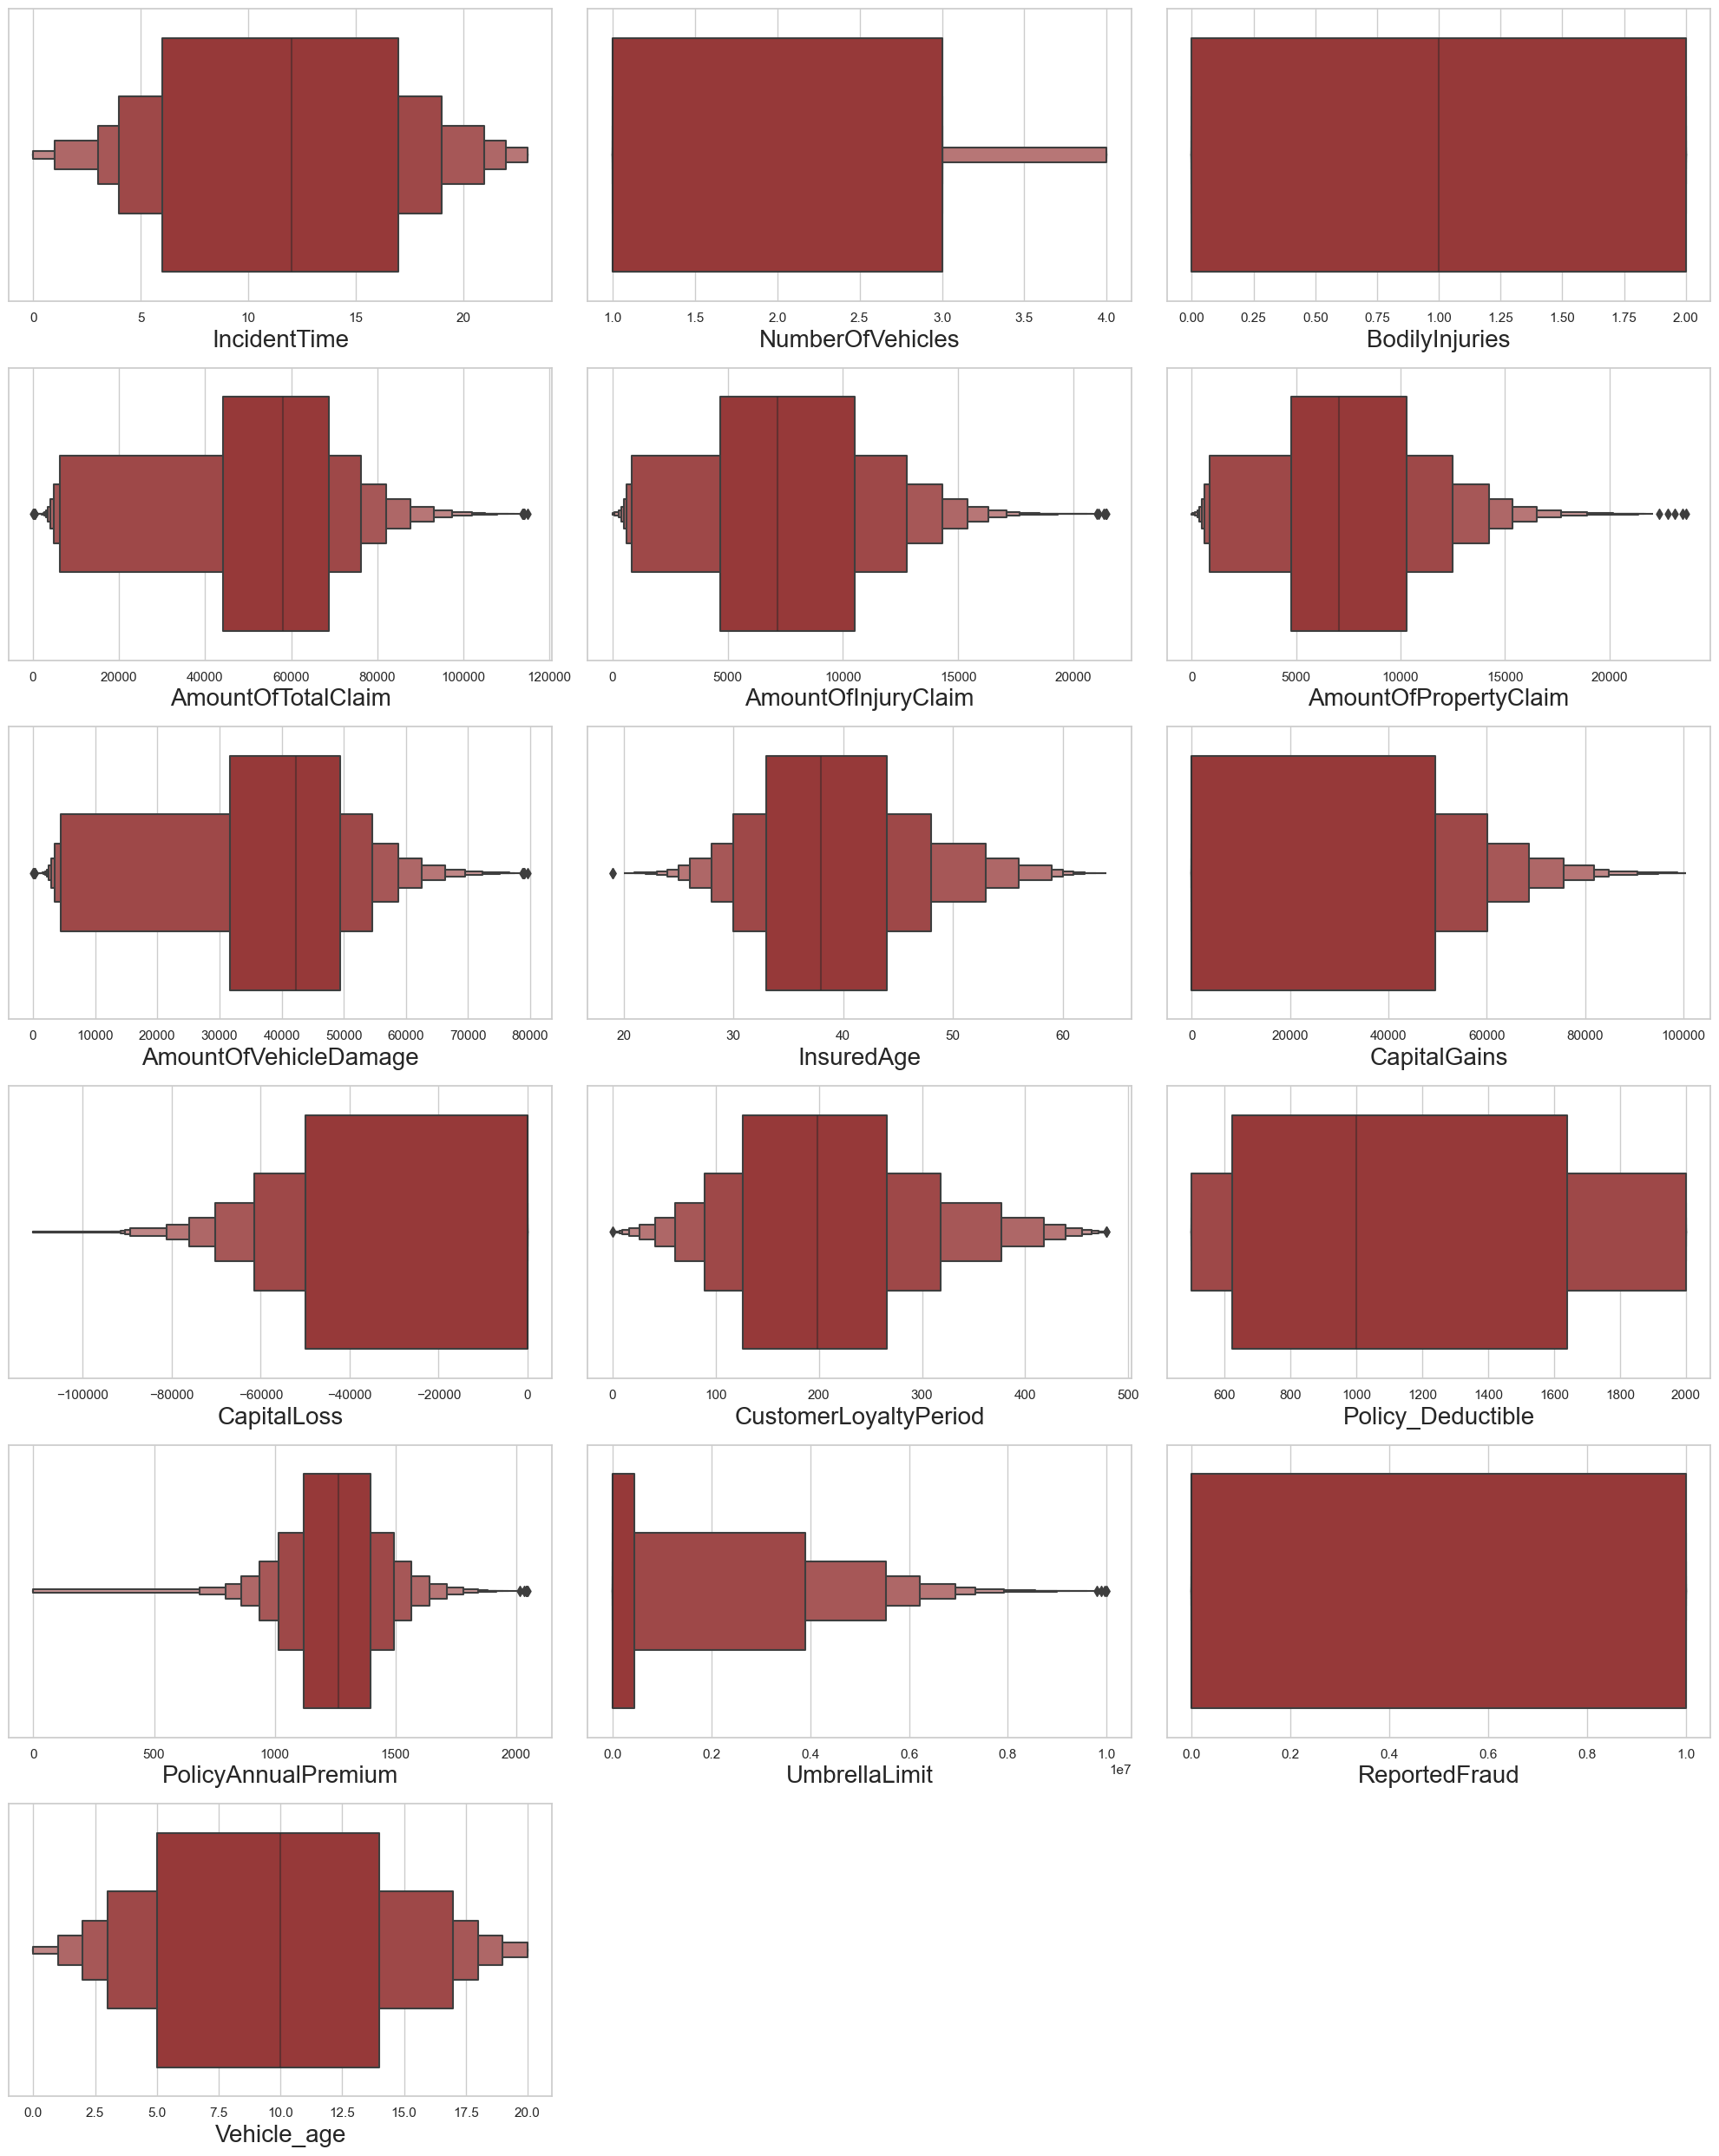

In [96]:
#lets check distribution after treating outliers
num_data = df._get_numeric_data()
plt.figure(figsize = (20,25))
plotnumber = 1
for column in num_data:
    if plotnumber <=16:
        ax = plt.subplot(6,3,plotnumber)
        sns.boxenplot(num_data[column], color="brown")
        plt.xlabel(column,fontsize = 20)
    plotnumber+=1
plt.tight_layout()

## Outlier Treatment

After visualizing the outliers with above Box-plots and based on our data analysis till now, we can conclude that these outlier data is not significantly affecting the other variables. So I have decided not to drop outliers instead I am using Quantile based flooring and capping method to treat outliers.

In [97]:
for col in ['PolicyAnnualPremium','UmbrellaLimit','AmountOfTotalClaim','AmountOfPropertyClaim','AmountOfInjuryClaim','AmountOfVehicleDamage','CapitalGains',]:
    percentile = df[col].quantile([0.01,0.98]).values
    df[col][df[col]<=percentile[0]]=percentile[0]
    df[col][df[col]>=percentile[1]]=percentile[1]

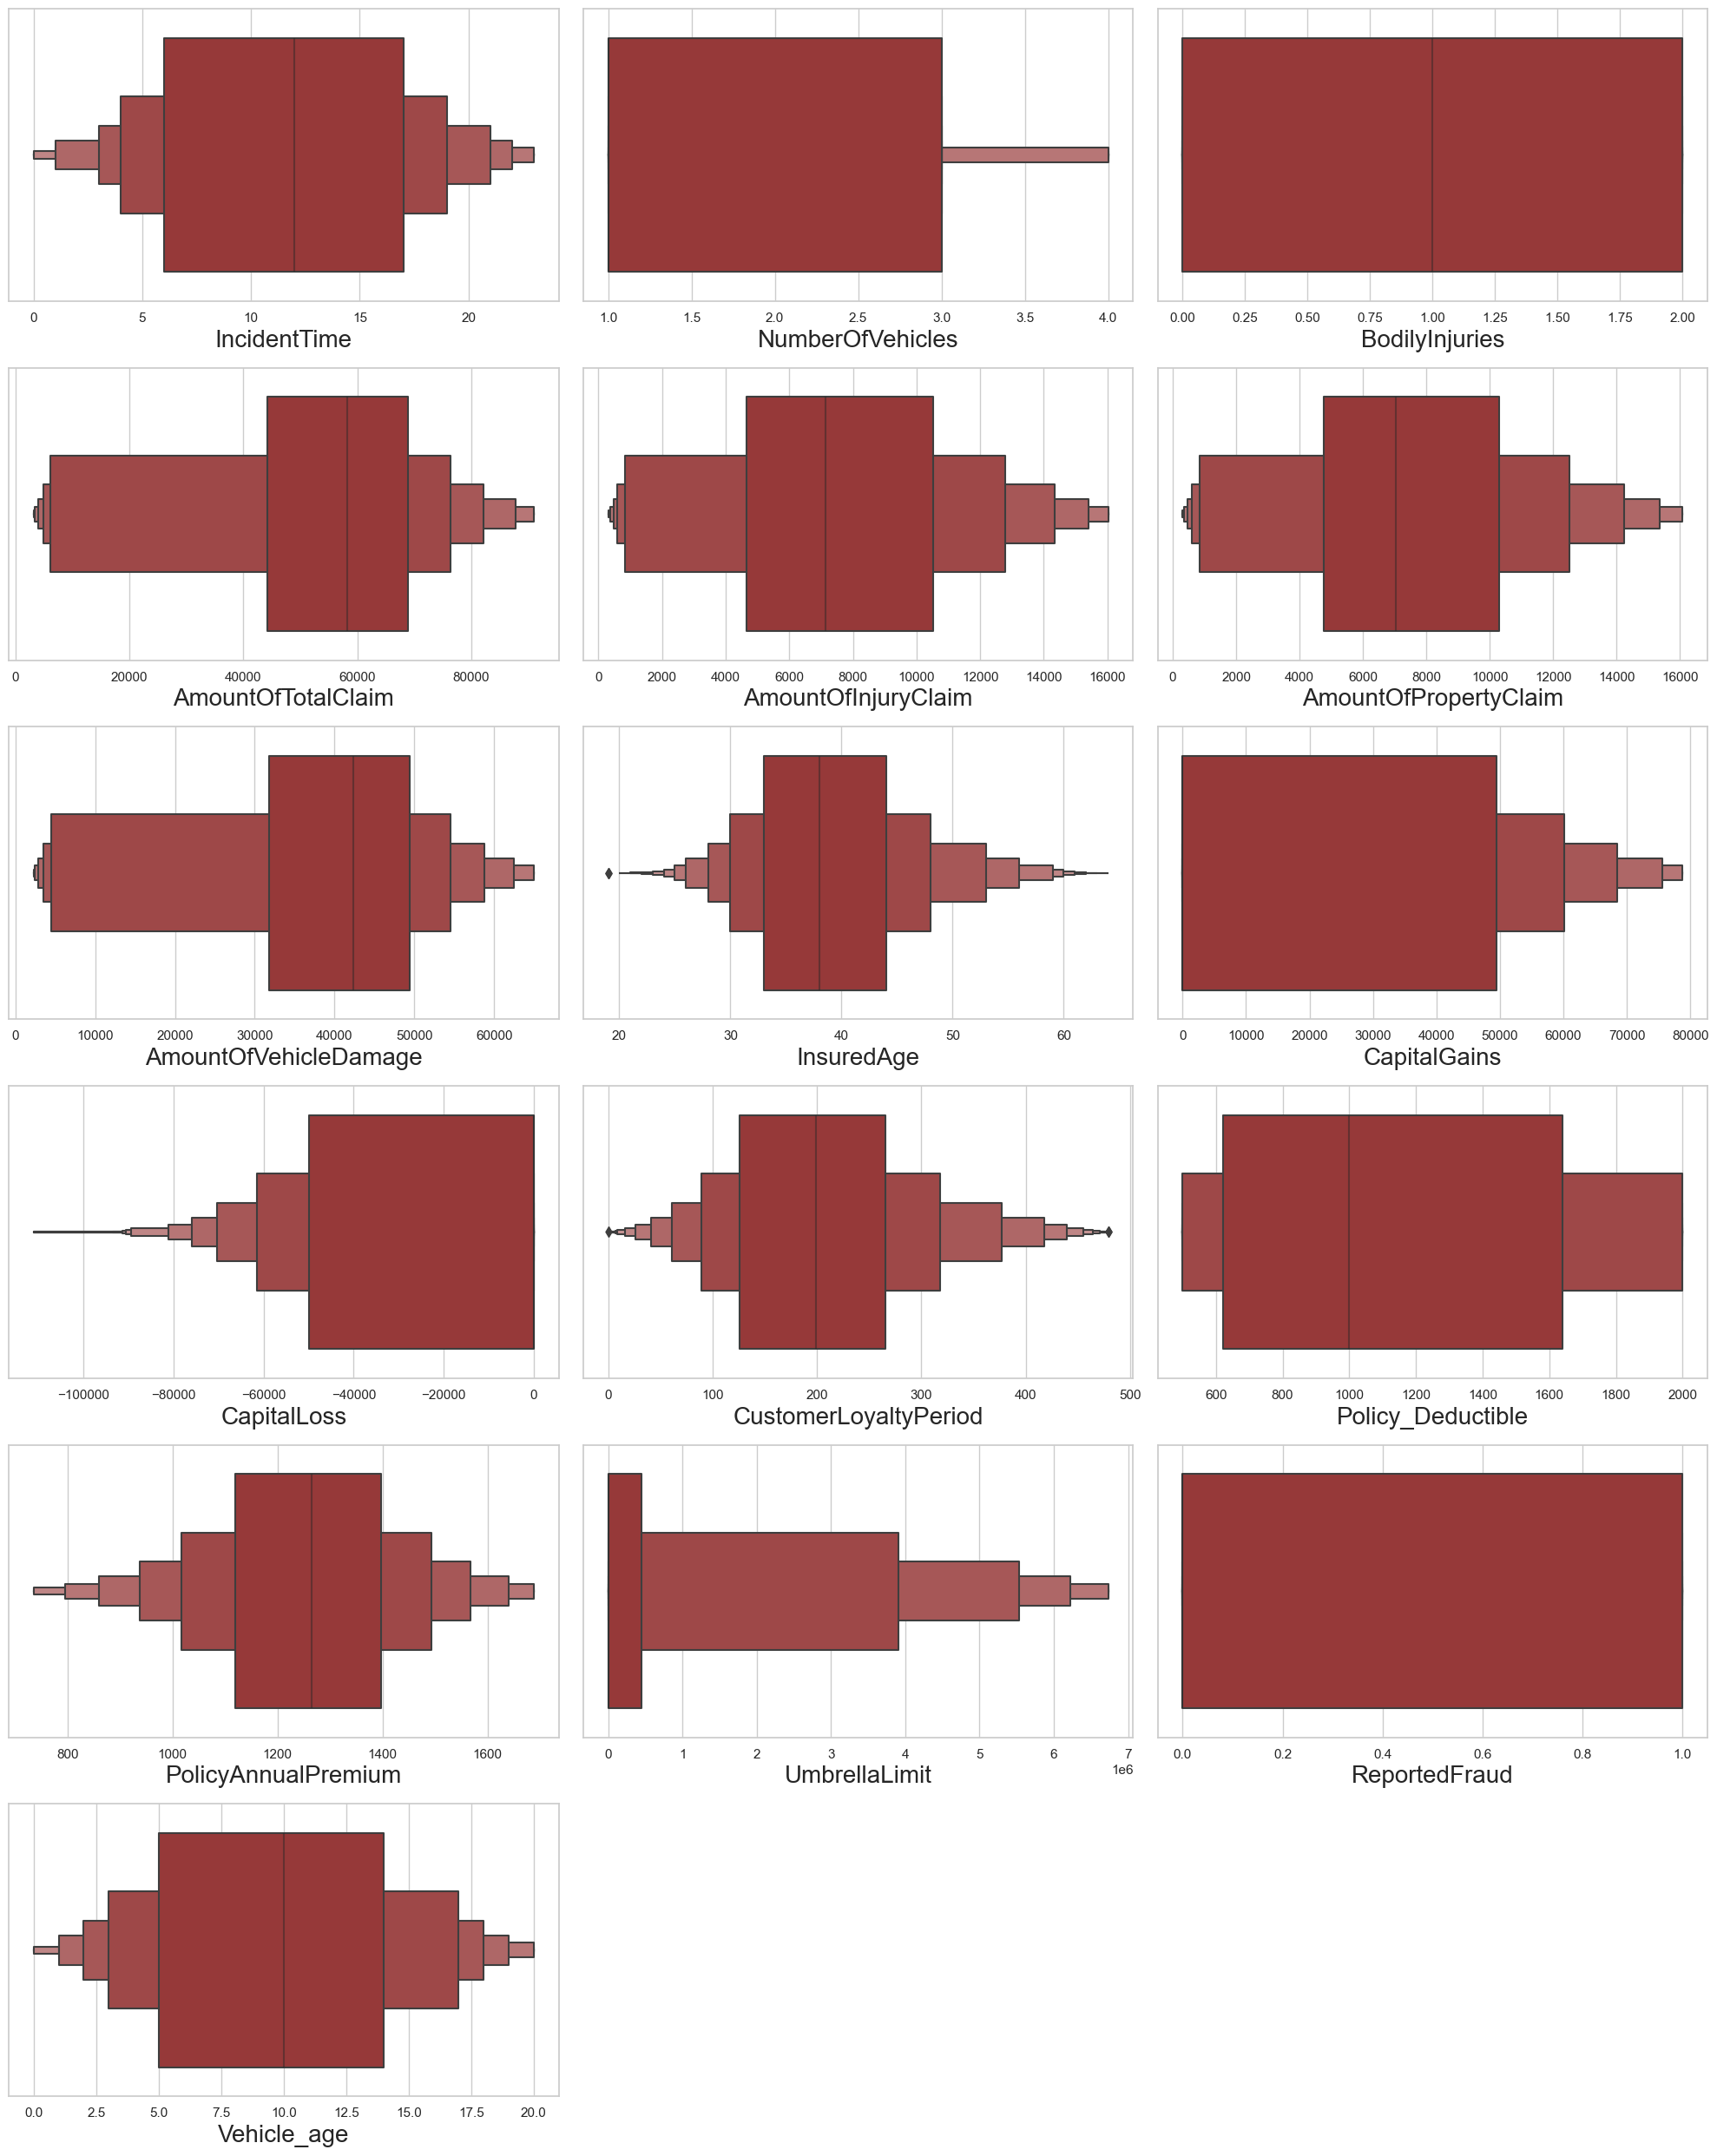

In [98]:
#lets check distribution after treating outliers
num_data = df._get_numeric_data()
plt.figure(figsize = (20,25))
plotnumber = 1
for column in num_data:
    if plotnumber <=18:
        ax = plt.subplot(6,3,plotnumber)
        sns.boxenplot(num_data[column], color="brown")
        plt.xlabel(column,fontsize = 20)
    plotnumber+=1
plt.tight_layout()

## Devide Train and Test Data set using source column

In [99]:
#Divide into test and train:
train = df.loc[df['source']=="train"]
test = df.loc[df['source']=="test"]
test.reset_index(drop=True,inplace=True)

In [100]:
train

TypeOfIncident TypeOfCollission SeverityOfIncident  \
0       Multi-vehicle Collision   Side Collision         Total Loss   
1       Multi-vehicle Collision   Side Collision         Total Loss   
2      Single Vehicle Collision   Side Collision       Minor Damage   
3      Single Vehicle Collision   Side Collision       Minor Damage   
4      Single Vehicle Collision   Rear Collision       Minor Damage   
...                         ...              ...                ...   
28831             Vehicle Theft            Other     Trivial Damage   
28832  Single Vehicle Collision  Front Collision       Minor Damage   
28833  Single Vehicle Collision   Rear Collision       Minor Damage   
28834  Single Vehicle Collision   Rear Collision       Minor Damage   
28835  Single Vehicle Collision  Front Collision         Total Loss   

      AuthoritiesContacted IncidentState IncidentCity  IncidentTime  \
0                   Police        State7        City1            17   
1                   Police        State7        City5            10   
2                    Other        State8        City6            22   
3                    Other        State9        City6            22   
4                     Fire        State8        City6            10   
...                    ...           ...          ...           ...   
28831               Police        State9        City4             3   
28832                 Fire        State8        City3            17   
28833                 Fire        State9        City7             1   
28834            Ambulance        State9        City3             1   
28835                Other        State8        City3             9   

       NumberOfVehicles PropertyDamage  BodilyInjuries  ... UmbrellaLimit  \
0                     3          Other               1  ...           0.0   
1                     3            YES               2  ...           0.0   
2                     1            YES               2  ...           0.0   
3                     1            YES               2  ...           0.0   
4                     1             NO               2  ...     4279863.0   
...                 ...            ...             ...  ...           ...   
28831                 1             NO               0  ...           0.0   
28832                 1            YES               0  ...           0.0   
28833                 1            YES               2  ...     3448735.0   
28834                 1          Other               2  ...     3364301.0   
28835                 1             NO               1  ...     2909175.0   

      InsuredRelationship  VehicleMake  VehicleModel  ReportedFraud  source  \
0           not-in-family         Audi            A5            0.0   train   
1           not-in-family         Audi            A5            0.0   train   
2                    wife   Volkswagen         Jetta            0.0   train   
3               own-child   Volkswagen         Jetta            0.0   train   
4               unmarried       Toyota           CRV            0.0   train   
...                   ...          ...           ...            ...     ...   
28831           unmarried       Suburu       Impreza            0.0   train   
28832           unmarried         Jeep      Wrangler            0.0   train   
28833           own-child       Suburu        Legacy            0.0   train   
28834       not-in-family       Suburu     Forrestor            0.0   train   
28835             husband       Suburu          E400            0.0   train   

       csl_per_person csl_per_accident Vehicle_age IncidentMonth  
0                 100              300           7            02  
1                 100              300           9            02  
2                 500             1000          16            01  
3                 500             1000          12            01  
4                 100              300           5            01  
...               ...              

In [101]:
test

TypeOfIncident TypeOfCollission SeverityOfIncident  \
0      Multi-vehicle Collision  Front Collision       Minor Damage   
1     Single Vehicle Collision   Rear Collision       Minor Damage   
2      Multi-vehicle Collision   Rear Collision       Minor Damage   
3                Vehicle Theft            Other     Trivial Damage   
4      Multi-vehicle Collision   Rear Collision       Minor Damage   
...                        ...              ...                ...   
8907   Multi-vehicle Collision            Other         Total Loss   
8908   Multi-vehicle Collision   Rear Collision       Major Damage   
8909   Multi-vehicle Collision   Side Collision         Total Loss   
8910  Single Vehicle Collision  Front Collision         Total Loss   
8911   Multi-vehicle Collision  Front Collision         Total Loss   

     AuthoritiesContacted IncidentState IncidentCity  IncidentTime  \
0               Ambulance        State5        City2             4   
1                    Fire        State9        City5            16   
2                  Police        State5        City2            20   
3                    None        State7        City5            10   
4                  Police        State5        City2             7   
...                   ...           ...          ...           ...   
8907               Police        State9        City7             4   
8908                Other        State9        City1             8   
8909            Ambulance        State8        City3             4   
8910                Other        State7        City4            18   
8911            Ambulance        State9        City1             3   

      NumberOfVehicles PropertyDamage  BodilyInjuries  ... UmbrellaLimit  \
0                    3             NO               0  ...           0.0   
1                    1          Other               1  ...           0.0   
2                    3             NO               0  ...     1235986.0   
3                    1          Other               2  ...     5873212.0   
4                    3             NO               2  ...     5000000.0   
...                ...            ...             ...  ...           ...   
8907                 2            YES               1  ...           0.0   
8908                 3          Other               1  ...           0.0   
8909                 4             NO               2  ...           0.0   
8910                 1          Other               1  ...           0.0   
8911                 3          Other               1  ...           0.0   

     InsuredRelationship  VehicleMake  VehicleModel  ReportedFraud  source  \
0              own-child   Volkswagen        Passat            NaN    test   
1              unmarried       Nissan        Ultima            NaN    test   
2         other-relative       Suburu       Impreza            NaN    test   
3                   wife       Accura            TL            NaN    test   
4              own-child        Dodge           RAM            NaN    test   
...                  ...          ...           ...            ...     ...   
8907       not-in-family   Volkswagen         Jetta            NaN    test   
8908             husband       Nissan         Jetta            NaN    test   
8909                wife   Volkswagen         Jetta            NaN    test   
8910           own-child   Volkswagen         Jetta            NaN    test   
8911           own-child         Ford         Jetta            NaN    test   

      csl_per_person csl_per_accident Vehicle_age IncidentMonth  
0                500             1000          20            02  
1                100              300           9            01  
2                250              500           5            01  
3                500              500           6            01  
4                100              300           8            02  
...              ...              ...         ...           ...  
8907             100  

In [102]:
#drop source column from train and test
train.drop(columns=["source"],inplace=True)
test.drop(columns=["source","ReportedFraud"],inplace=True)

## Splitting the data into X features and y target

In [103]:
X = train.drop(columns=['ReportedFraud'])
y = train['ReportedFraud']

In [104]:
#Lets check the skewness present in our numerical data
X.skew()

IncidentTime            -0.046566
NumberOfVehicles         0.509554
BodilyInjuries           0.024941
Witnesses                0.009363
AmountOfTotalClaim      -0.837387
AmountOfInjuryClaim      0.035703
AmountOfPropertyClaim    0.065176
AmountOfVehicleDamage   -0.869049
InsuredAge               0.506413
CapitalGains             0.576766
CapitalLoss             -0.503664
CustomerLoyaltyPeriod    0.394522
Policy_Deductible        0.567654
PolicyAnnualPremium     -0.138283
UmbrellaLimit            1.840776
csl_per_person           0.393830
csl_per_accident         0.582745
Vehicle_age              0.047569
IncidentMonth            0.198850
dtype: float64

In [105]:
#Creating a class to treat skewed data using Power transform
class skewness_remove:
  def __init__(self,skew=0.55):
    self.skew=skew
  
  def fit(self,X,y=None):
    return self

  def transform(self,X):
    x=X.copy()
    X_num=X.select_dtypes(exclude='object')
    X_num = X_num.drop(['Policy_Deductible'], axis=1)
    skewness=X_num.apply(lambda x:x.skew())
    skewness_col=skewness[abs(skewness)>=self.skew].index
    X[skewness_col]=power_transform(X[skewness_col])
    return X

In [106]:
sk = skewness_remove()
sk.fit(X)
sk.transform(X)


TypeOfIncident TypeOfCollission SeverityOfIncident  \
0       Multi-vehicle Collision   Side Collision         Total Loss   
1       Multi-vehicle Collision   Side Collision         Total Loss   
2      Single Vehicle Collision   Side Collision       Minor Damage   
3      Single Vehicle Collision   Side Collision       Minor Damage   
4      Single Vehicle Collision   Rear Collision       Minor Damage   
...                         ...              ...                ...   
28831             Vehicle Theft            Other     Trivial Damage   
28832  Single Vehicle Collision  Front Collision       Minor Damage   
28833  Single Vehicle Collision   Rear Collision       Minor Damage   
28834  Single Vehicle Collision   Rear Collision       Minor Damage   
28835  Single Vehicle Collision  Front Collision         Total Loss   

      AuthoritiesContacted IncidentState IncidentCity  IncidentTime  \
0                   Police        State7        City1            17   
1                   Police        State7        City5            10   
2                    Other        State8        City6            22   
3                    Other        State9        City6            22   
4                     Fire        State8        City6            10   
...                    ...           ...          ...           ...   
28831               Police        State9        City4             3   
28832                 Fire        State8        City3            17   
28833                 Fire        State9        City7             1   
28834            Ambulance        State9        City3             1   
28835                Other        State8        City3             9   

       NumberOfVehicles PropertyDamage  BodilyInjuries  ... Policy_Deductible  \
0                     3          Other               1  ...               0.0   
1                     3            YES               2  ...               0.0   
2                     1            YES               2  ...               0.0   
3                     1            YES               2  ...               0.0   
4                     1             NO               2  ...               0.0   
...                 ...            ...             ...  ...               ...   
28831                 1             NO               0  ...               0.0   
28832                 1            YES               0  ...               0.0   
28833                 1            YES               2  ...               0.0   
28834                 1          Other               2  ...               0.0   
28835                 1             NO               1  ...               0.0   

      PolicyAnnualPremium  UmbrellaLimit  InsuredRelationship  VehicleMake  \
0                 1632.73      -0.605049        not-in-family         Audi   
1                 1255.19      -0.605049        not-in-family         Audi   
2                 1373.38      -0.605049                 wife   Volkswagen   
3                 1337.60      -0.605049            own-child   Volkswagen   
4                 1353.73       1.664067            unmarried       Toyota   
...                   ...            ...                  ...          ...   
28831             1276.01      -0.605049            unmarried       Suburu   
28832             1273.38      -0.605049            unmarried         Jeep   
28833             1380.92       1.660018            own-child       Suburu   
28834             1389.29       1.659541        not-in-family       Suburu   
28835              928.43       1.656690              husband       Suburu   

       VehicleModel  csl_per_person csl_per_accident Vehicle_age IncidentMonth  
0                A5             100              300           7            02  
1                A5             100              300           9            02  
2             Jetta             500             1000          16            01  
3             Jetta             500             1000          12            0

In [107]:
X.skew()

IncidentTime            -0.046566
NumberOfVehicles         0.509554
BodilyInjuries           0.024941
Witnesses                0.009363
AmountOfTotalClaim      -0.616022
AmountOfInjuryClaim      0.035703
AmountOfPropertyClaim    0.065176
AmountOfVehicleDamage   -0.637413
InsuredAge               0.506413
CapitalGains             0.199521
CapitalLoss             -0.503664
CustomerLoyaltyPeriod    0.394522
Policy_Deductible        0.000000
PolicyAnnualPremium     -0.138283
UmbrellaLimit            1.048247
csl_per_person           0.393830
csl_per_accident         0.582745
Vehicle_age              0.047569
IncidentMonth            0.198850
dtype: float64

In [108]:
sk.transform(test)

TypeOfIncident TypeOfCollission SeverityOfIncident  \
0      Multi-vehicle Collision  Front Collision       Minor Damage   
1     Single Vehicle Collision   Rear Collision       Minor Damage   
2      Multi-vehicle Collision   Rear Collision       Minor Damage   
3                Vehicle Theft            Other     Trivial Damage   
4      Multi-vehicle Collision   Rear Collision       Minor Damage   
...                        ...              ...                ...   
8907   Multi-vehicle Collision            Other         Total Loss   
8908   Multi-vehicle Collision   Rear Collision       Major Damage   
8909   Multi-vehicle Collision   Side Collision         Total Loss   
8910  Single Vehicle Collision  Front Collision         Total Loss   
8911   Multi-vehicle Collision  Front Collision         Total Loss   

     AuthoritiesContacted IncidentState IncidentCity  IncidentTime  \
0               Ambulance        State5        City2             4   
1                    Fire        State9        City5            16   
2                  Police        State5        City2            20   
3                    None        State7        City5            10   
4                  Police        State5        City2             7   
...                   ...           ...          ...           ...   
8907               Police        State9        City7             4   
8908                Other        State9        City1             8   
8909            Ambulance        State8        City3             4   
8910                Other        State7        City4            18   
8911            Ambulance        State9        City1             3   

      NumberOfVehicles PropertyDamage  BodilyInjuries  ... Policy_Deductible  \
0                    3             NO               0  ...              2000   
1                    1          Other               1  ...               500   
2                    3             NO               0  ...              1000   
3                    1          Other               2  ...              2000   
4                    3             NO               2  ...              2000   
...                ...            ...             ...  ...               ...   
8907                 2            YES               1  ...              1487   
8908                 3          Other               1  ...              2000   
8909                 4             NO               2  ...              2000   
8910                 1          Other               1  ...              2000   
8911                 3          Other               1  ...              2000   

     PolicyAnnualPremium  UmbrellaLimit  InsuredRelationship  VehicleMake  \
0                1006.00      -0.593029            own-child   Volkswagen   
1                1279.17      -0.593029            unmarried       Nissan   
2                1454.67       1.673520       other-relative       Suburu   
3                1287.76       1.702080                 wife       Accura   
4                1413.14       1.699579            own-child        Dodge   
...                  ...            ...                  ...          ...   
8907             1412.51      -0.593029        not-in-family   Volkswagen   
8908             1451.31      -0.593029              husband       Nissan   
8909             1537.83      -0.593029                 wife   Volkswagen   
8910             1223.43      -0.593029            own-child   Volkswagen   
8911             1475.66      -0.593029            own-child         Ford   

      VehicleModel  csl_per_person csl_per_accident Vehicle_age IncidentMonth  
0           Passat             500             1000          20            02  
1           Ultima             100              300           9            01  
2          Impreza             250              500           5            01  
3               TL             500              500           6            01  
4              RAM             100              

Great, we have reduced the skewness from most of the columns to a acceptable extent.

## Encoding

In [109]:
from sklearn.preprocessing import OneHotEncoder
# specify the columns to be one-hot encoded
columns_to_encode = list(X.select_dtypes(include=['object']).columns)
# initialize the one-hot encoder object
encoder = OneHotEncoder(handle_unknown='ignore',drop='first')
# loop over each column to encode and append to the dataframe
for column in columns_to_encode:
    # fit and transform the encoder on the selected column
    encoded_array_tr = encoder.fit_transform(X[[column]]).toarray()
    encoded_array_test = encoder.transform(test[[column]]).toarray()
    # create a dataframe with the encoded values
    encoded_train = pd.DataFrame(encoded_array_tr, columns=encoder.get_feature_names([column]))
    encoded_test = pd.DataFrame(encoded_array_test, columns=encoder.get_feature_names([column]))
    # add the new columns to the original dataframe
    X = pd.concat([X, encoded_train], axis=1)
    test = pd.concat([test, encoded_test], axis=1)
# drop the original columns that have been encoded
X = X.drop(columns_to_encode, axis=1)
test = test.drop(columns_to_encode, axis=1)

In [110]:
X

IncidentTime  NumberOfVehicles  BodilyInjuries  AmountOfTotalClaim  \
0                17                 3               1            0.521291   
1                10                 3               2            0.333475   
2                22                 1               2            0.579031   
3                22                 1               2            0.555425   
4                10                 1               2           -0.015687   
...             ...               ...             ...                 ...   
28831             3                 1               0           -1.773389   
28832            17                 1               0            0.943383   
28833             1                 1               2            0.061779   
28834             1                 1               2            0.084986   
28835             9                 1               1            0.681593   

       AmountOfInjuryClaim  AmountOfPropertyClaim  AmountOfVehicleDamage  \
0                    13417                 6071.0               0.446903   
1                    15560                 5919.0               0.060247   
2                    11630                11630.0               0.285867   
3                    12003                12003.0               0.206289   
4                     8829                 7234.0              -0.089018   
...                    ...                    ...                    ...   
28831                  870                 1078.0              -1.782680   
28832                14699                 7875.0               0.836911   
28833                 7043                 7043.0               0.142332   
28834                 7059                 7059.0               0.173255   
28835                12075                 6038.0               0.762906   

       InsuredAge  CapitalGains  CapitalLoss  ...  VehicleModel_Ultima  \
0              35      1.125650       -48500  ...                  0.0   
1              36      1.155023       -48500  ...                  0.0   
2              33      1.146843       -63700  ...                  0.0   
3              36      1.102810       -73400  ...                  0.0   
4              29     -0.906431       -41500  ...                  0.0   
...           ...           ...          ...  ...                  ...   
28831          46     -0.906431            0  ...                  0.0   
28832          44     -0.906431       -28800  ...                  0.0   
28833          53      1.140022       -43800  ...                  0.0   
28834          53      1.148839       -43800  ...                  0.0   
28835          36      1.098478       -74300  ...                  0.0   

       VehicleModel_Wrangler  VehicleModel_X5  VehicleModel_X6  \
0                        0.0              0.0              0.0   
1                        0.0              0.0              0.0   
2                        0.0              0.0              0.0   
3                        0.0              0.0              0.0   
4                        0.0              0.0              0.0   
...                      ...              ...              ...   
28831                    0.0              0.0              0.0   
28832                    1.0              0.0              0.0   
28833                    0.0              0.0              0.0   
28834                    0.0              0.0              0.0   
28835                    0.0              0.0              0.0   

       csl_per_person_250  csl_per_person_500  csl_per_accident_300  \
0                     0.0                 0.0                   1.0   
1                     0.0                 0.0                   1.0   
2                     0.0                 1.0                   0.0   
3                     0.0                 1.0                   0.0   
4                     0.0                 0.0                   1.0   
...                   ...                 ...                

In [111]:
test

IncidentTime  NumberOfVehicles  BodilyInjuries  AmountOfTotalClaim  \
0                4                 3               0            0.687517   
1               16                 1               1            0.124463   
2               20                 3               0            0.304937   
3               10                 1               2           -1.757372   
4                7                 3               2           -0.716209   
...            ...               ...             ...                 ...   
8907             4                 2               1           -0.826088   
8908             8                 3               1            0.528944   
8909             4                 4               2            1.048370   
8910            18                 1               1            0.255699   
8911             3                 3               1            0.465736   

      AmountOfInjuryClaim  AmountOfPropertyClaim  AmountOfVehicleDamage  \
0                    6835                 8059.0               0.957062   
1                    8113                 5240.0               0.249628   
2                    7490                 9110.0               0.309529   
3                     494                  866.0              -1.759380   
4                    7700                 3850.0              -0.824329   
...                   ...                    ...                    ...   
8907                 2717                 7628.0              -0.911174   
8908                 8025                11338.0               0.456853   
8909                15275                 7638.0               0.966203   
8910                 5941                 9785.0               0.292757   
8911                 5808                11300.0               0.505228   

      InsuredAge  CapitalGains  CapitalLoss  ...  VehicleModel_Ultima  \
0             27      1.112923       -57000  ...                  0.0   
1             40      1.113666       -65600  ...                  1.0   
2             39      1.025028            0  ...                  0.0   
3             38      1.140018            0  ...                  0.0   
4             29      1.045712            0  ...                  0.0   
...          ...           ...          ...  ...                  ...   
8907          34      1.122041            0  ...                  0.0   
8908          51     -0.917213            0  ...                  0.0   
8909          46     -0.917213            0  ...                  0.0   
8910          50     -0.917213            0  ...                  0.0   
8911          46     -0.917213       -90600  ...                  0.0   

      VehicleModel_Wrangler  VehicleModel_X5  VehicleModel_X6  \
0                       0.0              0.0              0.0   
1                       0.0              0.0              0.0   
2                       0.0              0.0              0.0   
3                       0.0              0.0              0.0   
4                       0.0              0.0              0.0   
...                     ...              ...              ...   
8907                    0.0              0.0              0.0   
8908                    0.0              0.0              0.0   
8909                    0.0              0.0              0.0   
8910                    0.0              0.0              0.0   
8911                    0.0              0.0              0.0   

      csl_per_person_250  csl_per_person_500  csl_per_accident_300  \
0                    0.0                 1.0                   0.0   
1                    0.0                 0.0                   1.0   
2                    1.0                 0.0                   0.0   
3                    0.0                 1.0                   0.0   
4                    0.0                 0.0                   1.0   
...                  ...                 ...                   ...   
8907                 0.0                 0.0

### Splitting the data into train and test 

In [112]:
# split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
print("Shape of the X_train : ", X_train.shape)
print("Shape of the X_test : ", X_test.shape)
print("Shape of the y_train : ", y_train.shape)
print("Shape of the y_test : ", y_test.shape)

Shape of the X_train :  (23068, 151)
Shape of the X_test :  (5768, 151)
Shape of the y_train :  (23068,)
Shape of the y_test :  (5768,)


### Feature Scaling

In [114]:
# create an instance of StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training and test data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Check for data ImBalance

In [115]:
y_train.value_counts()

0.0    16799
1.0     6269
Name: ReportedFraud, dtype: int64

*We can clearly see that the data is imbalanced. So I am applying SMOTE method for Oversampling.*

In [119]:
# instantiate the SMOTE class
smote = SMOTE()
# apply SMOTE to the training data only
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_scaled, y_train)

In [120]:
y_train_oversampled.value_counts()

0.0    16799
1.0    16799
Name: ReportedFraud, dtype: int64

In [121]:
X_train_oversampled

array([[ 0.20216982, -0.83916375,  0.02023977, ...,  1.36743121,
         1.04451327, -0.09088922],
       [-0.9334469 , -0.83916375, -1.2519426 , ..., -0.73129821,
         1.04451327, -0.09088922],
       [ 0.52663174, -0.83916375,  1.29242214, ...,  1.36743121,
         1.04451327, -0.09088922],
       ...,
       [ 1.38572824,  2.22265353,  1.29242214, ..., -0.73129821,
        -0.95738372, -0.09088922],
       [-0.41897164,  1.20204777,  1.07955839, ..., -0.73129821,
         1.04451327, -0.09088922],
       [-0.92264401,  1.20204777, -1.2519426 , ..., -0.73129821,
         1.04451327, -0.09088922]])

Great, Now we have balanced our data and we are good to build our ML model with this data. Further required changes can be done based on model performance.

Here I have applied oversampling only to training data to avoid introducing bias into the validation set and obtain a more reliable estimate of the model's performance.

#### Checking results with Decision Tree Algorithm

In [122]:
#model with DecesionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_oversampled,y_train_oversampled)
pred_dt = dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test,pred_dt)*100

print(f"Accuracy Score:", accuracy)
#confusion matrix & classification report
print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred_dt)}\n")
print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred_dt)}")

#cross validation score
scores = cross_val_score(dt, X_train_oversampled, y_train_oversampled, cv = 5,scoring = "accuracy" ).mean()*100
print("\nCross validation score :", scores)

#result of accuracy minus cv score
result = accuracy - scores
print("\n\nAccuracy Score - Cross Validation Score :", result)

Accuracy Score: 83.58183079056866
Confusion Matrix : 
 [[3754  498]
 [ 449 1067]]

CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      4252
         1.0       0.68      0.70      0.69      1516

    accuracy                           0.84      5768
   macro avg       0.79      0.79      0.79      5768
weighted avg       0.84      0.84      0.84      5768


Cross validation score : 87.32090943238434


Accuracy Score - Cross Validation Score : -3.7390786418156807


## Top 20 Important Fratures Using Decision Tree

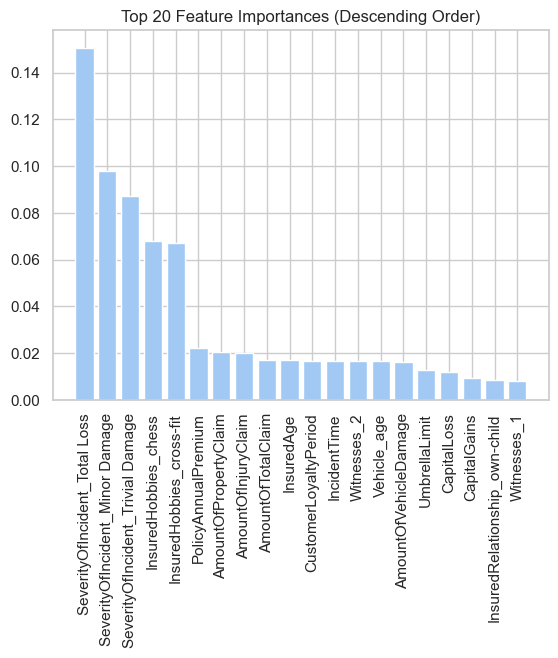

In [127]:
# Get feature importances and sort them in descending order
importances = dt.feature_importances_
indices = importances.argsort()[::-1]

# Select top 20 important features
top_features = 20
indices = indices[:top_features]
importances = importances[indices]

# Plot the feature importances in descending order
plt.bar(range(top_features), importances)
plt.xticks(range(top_features), X.columns[indices], rotation=90)
plt.title("Top 20 Feature Importances (Descending Order)")
plt.show()

We are getting much satisfactory results with our data, further we will test with different algorithms to select final model with better performance.

## Model Building with different Algorithms

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [129]:
models={
    "Logistic Regression":LogisticRegression(),
    "Decision Tree Classifier":DecisionTreeClassifier(),
    "KNN Classifier":KNeighborsClassifier(),
    "Random Forest Classifier":RandomForestClassifier(),
    "XGBoost Classifier":XGBClassifier(),
    "Extra Tree Classifier":ExtraTreesClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "LGBM Classifier": LGBMClassifier()
    
}

In [131]:
#model building and evaluation

for name, model in models.items():
    print("***********************************",name,"******************************************")
    clf = model
    clf.fit(X_train_oversampled,y_train_oversampled)
    pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test,pred)*100
    F1_score = f1_score(y_test,pred)

    print(f"Accuracy Score:", accuracy,'%')
    print(f"F1_Score:", F1_score)
    #confusion matrix & classification report
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

    #cross validation score
    scores = cross_val_score(clf, X_train_oversampled, y_train_oversampled, cv = 5,scoring = "accuracy" ).mean()*100
    print("\nCross validation score :", scores)

    #result of accuracy minus cv score
    result = accuracy - scores
    print("\nAccuracy Score - Cross Validation Score :", result)


*********************************** Logistic Regression ******************************************
Accuracy Score: 81.81345353675451 %
F1_Score: 0.6897367642709257
Confusion Matrix : 
 [[3553  699]
 [ 350 1166]]

CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

         0.0       0.91      0.84      0.87      4252
         1.0       0.63      0.77      0.69      1516

    accuracy                           0.82      5768
   macro avg       0.77      0.80      0.78      5768
weighted avg       0.84      0.82      0.82      5768


Cross validation score : 81.9186014783946

Accuracy Score - Cross Validation Score : -0.105147941640098
*********************************** Decision Tree Classifier ******************************************
Accuracy Score: 83.72052704576977 %
F1_Score: 0.697584541062802
Confusion Matrix : 
 [[3746  506]
 [ 433 1083]]

CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

         0.0       0.90      0.

## ROC curve and check AUC of all algorithms

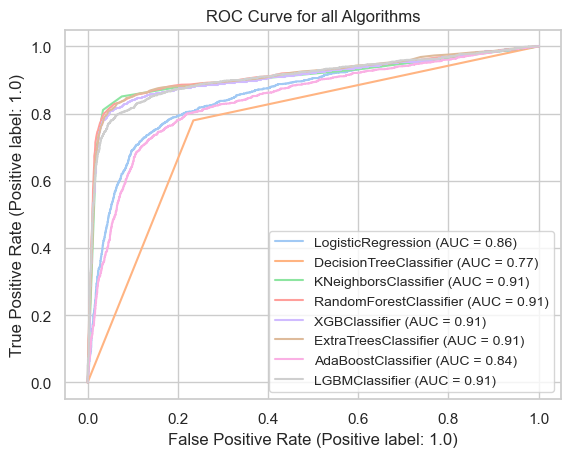

In [132]:
#Lets plot roc curve and check auc and performance of all algorithms
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(LogisticRegression().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test)
plot_roc_curve(DecisionTreeClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(KNeighborsClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(RandomForestClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(XGBClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(ExtraTreesClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(AdaBoostClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plot_roc_curve(LGBMClassifier().fit(X_train_undersampled,y_train_undersampled), X_test_scaled, y_test, ax = disp.ax_)
plt.title('ROC Curve for all Algorithms')

plt.legend(prop={"size" :10} ,loc = 'lower right')
plt.show()

In [138]:
# Define the parameter grid for GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2,3],
    'max_depth': [7,8],
    #'min_child_weight': [1, 2, 3],
    'n_estimators': [100, 150,300]
}

In [141]:
# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1',n_jobs=-1, verbose=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_oversampled,y_train_oversampled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 8], 'min_samples_split': [2, 3],
                         'n_estimators': [100, 150, 300]},
             scoring='f1', verbose=10)

In [142]:
# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 150}
Best Score:  0.8764503226737104


In [151]:
#Let's train and test our model using best parameters
model = RandomForestClassifier()
model.fit(X_train_oversampled,y_train_oversampled)
pred = model.predict(X_test_scaled)

# evaluation
accuracy = accuracy_score(y_test,pred)*100
F1_score = f1_score(y_test,pred)

print(f"Accuracy Score:", accuracy,'%')
print(f"F1_Score:", F1_score)
#confusion matrix & classification report
print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred_dt)}\n")
print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred_dt)}")


Accuracy Score: 92.68377253814147 %
F1_Score: 0.8500355366027008
Confusion Matrix : 
 [[3754  498]
 [ 449 1067]]

CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      4252
         1.0       0.68      0.70      0.69      1516

    accuracy                           0.84      5768
   macro avg       0.79      0.79      0.79      5768
weighted avg       0.84      0.84      0.84      5768



## Prediction on test Data

In [152]:
test_scaled = scaler.transform(test)

In [153]:
Test

CustomerID
0     Cust10008
1     Cust10010
2     Cust10015
3     Cust10020
4      Cust1003
...         ...
8907  Cust37942
8908  Cust20528
8909  Cust36797
8910  Cust28499
8911  Cust21356

[8912 rows x 1 columns]

In [154]:
#lets predict the sales with our best model
pred = model.predict(test_scaled)

In [155]:
#Lets create dataframe with test data
Test['ReportedFraud'] = pred  

In [156]:
Test

CustomerID  ReportedFraud
0     Cust10008            0.0
1     Cust10010            0.0
2     Cust10015            0.0
3     Cust10020            0.0
4      Cust1003            0.0
...         ...            ...
8907  Cust37942            0.0
8908  Cust20528            0.0
8909  Cust36797            0.0
8910  Cust28499            0.0
8911  Cust21356            0.0

[8912 rows x 2 columns]

In [157]:
Test.to_csv("Submission5.csv")